In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow_addons.losses import metric_learning
import tensorflow_probability as tfp
from keras import backend as K
import os
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import precision_recall_curve
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

/home/azim/miniconda3/envs/test1/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:38: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210310). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [2]:

all_features = []
feature_name = ['p90','p95','p80','p5','p10','p20','range_90_to_80','range_20_to_10','range_90_to_10',
                'range_80_to_20','median','iqr','skew']
name = 'current_window_stress'
all_features += [name+'_'+a for a in feature_name]
# print(len(set(all_features)),len(all_features))
name = 'current_window_stress_diff'
all_features += [name+'_'+a for a in feature_name]
name = 'daily_stress'
all_features += [name+'_'+a for a in feature_name]
all_features += ['percentage_of_stress', 'maximum_duration_of_current_stress_episode','average_duration_of_current_stress_episode',
               'maximum_density_of_current_stress_episode', 'average_density_of_current_stress_episode', 'average_deviation_to_daily_mean_current',
               'no_stress_till_now', 'time_since_last_stress', 'duration_of_last_stress_episode', 'average_duration_of_before_stress_episode',
               'density_of_last_stress_episode', 'average_density_of_before_stress_episode', 'deviation_to_daily_mean_of_last_stress_episode',
               'percentage_of_stress_before']
all_features+= ['percentage_of_active_', 'maximum_duration_of_current_activity_episode', 'average_duration_of_current_window_episode',
                 'no_activity_till_now', 'time_since_last_activity', 'duration_of_last_activity_episode', 'average_duration_of_before_activity_episode',
                 'percentage_of_active_before']
all_features += ['time_since_last_visit_smoking_spot','duration_of_stay_in_smoking_spot','fraction_of_minutes_spent_in_smoking_spots_out_of_observed']
all_features += ['Gender','Age']
all_features += ['is_smoking','spread','distance_to_nearest_spot',
                'time_spent_in_transition','time_spent_in_smoking_spot']
all_features += ['Time of day = {}'.format(a) for a in np.arange(24)]
feature_names = all_features


def get_X_y_groups(n_lag=10):
    data = pickle.load(open(filepath_file.format(n_lag),'rb'))

    X_feature = np.concatenate(data.feature_final.values)
    X_static =  np.concatenate(data.static_features.values)

    X_stress_episode = np.concatenate(data.stress_episode.values)
    X_quit_episode = np.concatenate(data.quit_episode.values)
    X_activity_episode = np.concatenate(data.activity_episode.values)
    X_smoking_episode = np.concatenate(data.smoking_episode.values)

    y_time = data['time'].values
    y = data['label'].values
    groups = data['user'].values
    
    return X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups

def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes


def get_train_test_indexes(groups,n_groups_split = 10,n_val_groups = 10):
    groups_unique = np.unique(groups)
    groups_split = np.array_split(groups_unique,n_groups_split)
    indexes = []
    for this_groups in groups_split:
        train_groups = np.array([a for a in groups_unique if a not in this_groups])
        val_groups = np.random.choice(train_groups,n_val_groups)
        train_groups = np.array([a for a in groups_unique if a not in list(this_groups)+list(val_groups)])
        test_groups = this_groups
        train_index,test_index = np.array([i for i,a in enumerate(groups) 
                                           if a in train_groups]),np.array([i for i,a in enumerate(groups) 
                                                                               if a in test_groups])
        val_index = np.array([i for i,a in enumerate(groups) 
                                           if a in val_groups])
        indexes.append([train_index,test_index,val_index])
    return indexes

class CenterLoss(tf.keras.losses.Loss):
    def __init__(
        self,
        alpha=0.9,
        update_centers=True,
        p = 80,
        name="center_loss",
        **kwargs
    ):
        super().__init__(name=name, **kwargs)
        self.alpha = alpha
        self.update_centers = update_centers
        self.p = p
        
    def consistency_loss(self,labels,precise_embeddings):
        
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_positive = tf.repeat(tf.transpose(tf.reshape(tf.cast(labels,tf.bool),[lshape[0],1])),lshape[0],axis=0)
        mask_only_positive = tf.math.multiply(tf.cast(mask_for_equal,tf.float32),tf.cast(only_positive,tf.float32))
        
        pdist_matrix = metric_learning.pairwise_distance(
                    precise_embeddings, squared=False
                )
        positive_only_dist = tf.boolean_mask(pdist_matrix, tf.cast(mask_only_positive,tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        positive_only_dist = tf.reshape(positive_only_dist,[no_of_positives,no_of_positives])
        positive_only_dist = tf.reduce_mean(positive_only_dist,axis=1)
        
        distance_95 = tf.reshape(positive_only_dist,(-1,))
        # if max_vs_percentile:
        #     return tf.reduce_max(distance_95),pdist_matrix
        # return tfp.stats.percentile(distance_95,self.p),pdist_matrix
        samples1 = tf.cast(no_of_positives, tf.float32) #batch size
        p = (100. - self.p)/100.  #100% will return 0 elements, 0% will return all elements
        samples = tf.cast(tf.math.floor(p * samples1), tf.int32)
        values, indices = tf.math.top_k(distance_95, samples)
        positive_dist_95th = tf.reduce_min(values)
        return positive_dist_95th, pdist_matrix
    
    
    def compute_rare_loss_v1(self,labels,pdist_matrix,positive_dist_95th):
        lshape = tf.shape(labels)
        labels = tf.reshape(labels, [lshape[0], 1])
        mask_for_equal = tf.math.equal(tf.cast(labels,tf.bool),tf.transpose(tf.cast(labels,tf.bool)))
        only_negative = tf.cast(tf.repeat(tf.transpose(tf.reshape(tf.cast(1-labels,tf.bool),[lshape[0],1])),lshape[0],axis=0),tf.int32)
        mask_negative_to_positive = tf.math.logical_not(tf.cast(tf.math.add(tf.cast(mask_for_equal,tf.int32),only_negative),tf.bool))
        no_of_positives = tf.cast(tf.reduce_sum(labels),tf.int32)
        no_of_negatives = lshape[0] - no_of_positives
        negative_to_positive_distance = tf.reshape(tf.boolean_mask(pdist_matrix,mask_negative_to_positive),[no_of_negatives,no_of_positives])
        average_neg_to_pos_distance = tf.reduce_mean(negative_to_positive_distance,axis=1)
        less_distance_mask = tf.reduce_sum(tf.where(average_neg_to_pos_distance<=positive_dist_95th,1,0))
        return tf.cast(less_distance_mask,tf.float32)/(tf.cast(no_of_negatives,tf.float32)+K.epsilon())
    def call(self, sparse_labels, prelogits):
        sparse_labels = tf.reshape(sparse_labels, (-1,))
        distance_95th, pdist_matrix = self.consistency_loss(sparse_labels,prelogits)
        rare_loss = self.compute_rare_loss_v1(sparse_labels,pdist_matrix,distance_95th)
        return tf.square(rare_loss-ratio_of_pos_to_neg) + distance_95th*.2

def get_model():
    n_t,n_f = train_feature.shape[1],train_feature.shape[2]
    print(n_t,n_f)
    x_input = Input(shape=(n_t,n_f))
    x_feature = Conv1D(100,1,activation='linear')(x_input)
    x_feature = Conv1D(100,1,activation='tanh')(x_feature)
    # x_feature = Dropout(.2)(x_feature)
    x_feature = LSTM(10,activation='tanh',return_sequences=False)(x_feature)
    x_feature = Dropout(.2)(x_feature)
    x_feature = Flatten()(x_feature)
    x_feature = Dense(10,activation='relu')(x_feature)
    merged_all = x_feature
    merged1 = Dense(10,activation='relu',name='normalize2')(merged_all)
    merged1 = Lambda(lambda x: K.l2_normalize(x,axis=1),name='normalize3')(merged1)
    merged = Dense(5,activation='relu',name='normalize')(merged1)
    output = Dense(1,activation='sigmoid',name='softmax')(merged)
    model = tf.keras.models.Model(inputs=[x_input], outputs=[output,merged1])
    myloss1 = CenterLoss()
    model.compile(
        loss={'softmax':tf.losses.BinaryCrossentropy(),'normalize3':tfa.losses.TripletSemiHardLoss()},
        loss_weights = {'softmax':softmax_weight,'normalize3':revised_loss_weight},
        metrics={'softmax':['acc']},
        optimizer='adam'
        )
    return model
    
def f1Bias_scorer_CV(probs, y, ret_bias=True):
    precision, recall, thresholds = precision_recall_curve(y, probs)

    f1,bias = 0.0,.5
    min_recall = .8
    for i in range(0, len(thresholds)):
        if not (precision[i] == 0 and recall[i] == 0) and thresholds[i]>0.2:
            f = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
            if f > f1:
                f1 = f
                bias = thresholds[i]

    if ret_bias:
        return f1, bias
    else:
        return f1
def set_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
    # Restrict TensorFlow to only use the first GPU
        try:
            tf.config.experimental.set_visible_devices(gpus[gpu_id], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            # Visible devices must be set before GPUs have been initialized
            print(e)
            
            
import shap

# we use the first 100 training examples as our background dataset to integrate over
def get_random_samples(X_feature_train,y_train):
    train_positive = X_feature_train[y_train==1]
    train_negative = X_feature_train[y_train==0]
    train_negative = train_negative[np.random.choice(np.arange(train_negative.shape[0]),min(train_positive.shape[0]*2,train_negative.shape[0]))]
    X_feature_train = np.concatenate([train_positive,train_negative])
    return X_feature_train


4 Physical GPUs, 1 Logical GPU
Instructions for updating:
non-resource variables are not supported in the long term
15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2001308044473512 AUC 0.5298892678021921 step 0 stagnant 0
Validation Result now 0.24855491329479765 AUC 0.5758957329998852 step 20 stagnant 0
Validation Result now 0.21930870083432655 AUC 0.5117678894843883 step 40 stagnant 0
Validation Result now 0.2380538662033015 AUC 0.508958974636649 step 60 stagnant 20
Validation Result now 0.23822341857335128 AUC 0.5180219409863476 step 80 stagnant 40
Validation Result now 0.2273730684326711 AUC 0.5334519328036419 step 100 stagnant 60
Validation Result now 0.2550505050505051 AUC 0.5718142480285853 step 120 stagnant 80
Validation Result now 0.23793337865397687 AUC 0.5602485224827047 step 140 stagnant 0
Validation Result now 0.2511467889908257 AUC 0.6338006466209778 step 160 stagnant 20
Validation Result now 0.24845573095401513 AUC 0.5823705454985251 step 180 stagnant 40
Validation Result now 0.2216142270861833 AUC 0.5371271922389289 step 200 stagnant 60
Validation Result now 0.2246065808297568 AUC 0.5761574834309067 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.26456984273820533 AUC 0.6104794296294909 step 0 stagnant 0
Validation Result now 0.23098201936376211 AUC 0.5524977240743093 step 20 stagnant 0
Validation Result now 0.2857142857142857 AUC 0.6046020001831873 step 40 stagnant 20
Validation Result now 0.2812960235640648 AUC 0.5692248290715286 step 60 stagnant 0
Validation Result now 0.26086956521739135 AUC 0.579573902178968 step 80 stagnant 20
Validation Result now 0.23884349465744817 AUC 0.5248994367242054 step 100 stagnant 40
Validation Result now 0.23931623931623927 AUC 0.5208164336257077 step 120 stagnant 60
Validation Result now 0.23628691983122363 AUC 0.5503094702292726 step 140 stagnant 80
Validation Result now 0.2642998027613412 AUC 0.5590670399910127 step 160 stagnant 100
Validation Result now 0.261758691206544 AUC 0.6066662736404033 step 180 stagnant 120
Validation Result now 0.26269702276707524 AUC 0.5627426789580992 step 200 stagnant 140
Validation Result now 0.26812313803376364 AUC 0.5850656008064291 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2025171624713959 AUC 0.5607936566573167 step 0 stagnant 0
Validation Result now 0.2725409836065574 AUC 0.636118573830827 step 20 stagnant 0
Validation Result now 0.29166666666666663 AUC 0.6649693161191204 step 40 stagnant 0
Validation Result now 0.21884200196270853 AUC 0.5596812489531249 step 60 stagnant 0
Validation Result now 0.24023581429624172 AUC 0.5774844531123884 step 80 stagnant 20
Validation Result now 0.2045959970348406 AUC 0.5274002982613901 step 100 stagnant 40
Validation Result now 0.23537414965986392 AUC 0.5814897787025983 step 120 stagnant 60
Validation Result now 0.23435225618631733 AUC 0.5494426195993257 step 140 stagnant 80
Validation Result now 0.27424749163879597 AUC 0.5723902507895526 step 160 stagnant 100
Validation Result now 0.239731768650461 AUC 0.5553339652116092 step 180 stagnant 120
Validation Result now 0.24881033310673012 AUC 0.5375191220771623 step 200 stagnant 140
Validation Result now 0.2265193370165746 AUC 0.5259589629976738 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2123287671232877 AUC 0.5155948351288562 step 0 stagnant 0
Validation Result now 0.24082865774708673 AUC 0.5713843650104068 step 20 stagnant 0
Validation Result now 0.22499999999999998 AUC 0.581968115280507 step 40 stagnant 0
Validation Result now 0.18823529411764706 AUC 0.5736494107895324 step 60 stagnant 20
Validation Result now 0.18846549948506697 AUC 0.5772764696862892 step 80 stagnant 40
Validation Result now 0.16522811344019728 AUC 0.5531169934604141 step 100 stagnant 60
Validation Result now 0.23866090712742982 AUC 0.5959222344403349 step 120 stagnant 80
Validation Result now 0.17583807716635041 AUC 0.5695676727970329 step 140 stagnant 100
Validation Result now 0.200587084148728 AUC 0.5383864787495085 step 160 stagnant 120
Validation Result now 0.18782791185729275 AUC 0.538319681152805 step 180 stagnant 140
Validation Result now 0.19313984168865433 AUC 0.5225930219789395 step 200 stagnant 160
Validation Result now 0.18369987063389395 AUC 0.5226770250172181

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.243606998654105 AUC 0.6691520095702739 step 0 stagnant 0
Validation Result now 0.21714285714285717 AUC 0.6006954793714346 step 20 stagnant 0
Validation Result now 0.23698959167333866 AUC 0.5815425336227221 step 40 stagnant 20
Validation Result now 0.23497757847533632 AUC 0.5455385024889694 step 60 stagnant 40
Validation Result now 0.2218091697645601 AUC 0.5566610614036909 step 80 stagnant 60
Validation Result now 0.19546742209631726 AUC 0.5843585330640513 step 100 stagnant 80
Validation Result now 0.2532894736842105 AUC 0.6366966007613915 step 120 stagnant 100
Validation Result now 0.20794701986754968 AUC 0.6053706785876761 step 140 stagnant 0
Validation Result now 0.23639455782312924 AUC 0.5897984888561872 step 160 stagnant 20
Validation Result now 0.24410774410774413 AUC 0.6078865948862391 step 180 stagnant 40
Validation Result now 0.24166666666666667 AUC 0.595356985080352 step 200 stagnant 60
Validation Result now 0.2587749483826565 AUC 0.6069481392567958 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2997685185185185 AUC 0.5515549670844722 step 0 stagnant 0
Validation Result now 0.2634289919058131 AUC 0.5148389342949489 step 20 stagnant 0
Validation Result now 0.22746781115879827 AUC 0.532380261512591 step 40 stagnant 20
Validation Result now 0.1838150289017341 AUC 0.5174293653368041 step 60 stagnant 40
Validation Result now 0.19574468085106383 AUC 0.51315027080859 step 80 stagnant 60
Validation Result now 0.20508474576271185 AUC 0.5042115378679118 step 100 stagnant 80
Validation Result now 0.24024960998439937 AUC 0.5899208246062104 step 120 stagnant 100
Validation Result now 0.2446043165467626 AUC 0.6302288728563411 step 140 stagnant 120
Validation Result now 0.1966955153422502 AUC 0.5601972856897788 step 160 stagnant 140
Validation Result now 0.2432629278951202 AUC 0.6110427813304765 step 180 stagnant 160
Validation Result now 0.22237860661505982 AUC 0.49692250314884884 step 200 stagnant 180
Validation Result now 0.23644444444444446 AUC 0.5144544685821046 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21936520691040579 AUC 0.5749980137835828 step 0 stagnant 0
Validation Result now 0.191904047976012 AUC 0.5819622957929154 step 20 stagnant 0
Validation Result now 0.22263450834879406 AUC 0.5692253351139278 step 40 stagnant 20
Validation Result now 0.2333931777378815 AUC 0.5415877029672809 step 60 stagnant 0
Validation Result now 0.23431734317343175 AUC 0.5787725840397263 step 80 stagnant 0
Validation Result now 0.2 AUC 0.55315444059796 step 100 stagnant 0
Validation Result now 0.22655122655122656 AUC 0.5593790151301616 step 120 stagnant 20
Validation Result now 0.20235756385068762 AUC 0.5655431175956509 step 140 stagnant 40
Validation Result now 0.1990521327014218 AUC 0.567439891018709 step 160 stagnant 60
Validation Result now 0.26705653021442494 AUC 0.594803501206152 step 180 stagnant 80
Validation Result now 0.24344176285414482 AUC 0.602122265916172 step 200 stagnant 0
Validation Result now 0.22369668246445498 AUC 0.587946879717264 step 220 stagnant 20
Valida

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


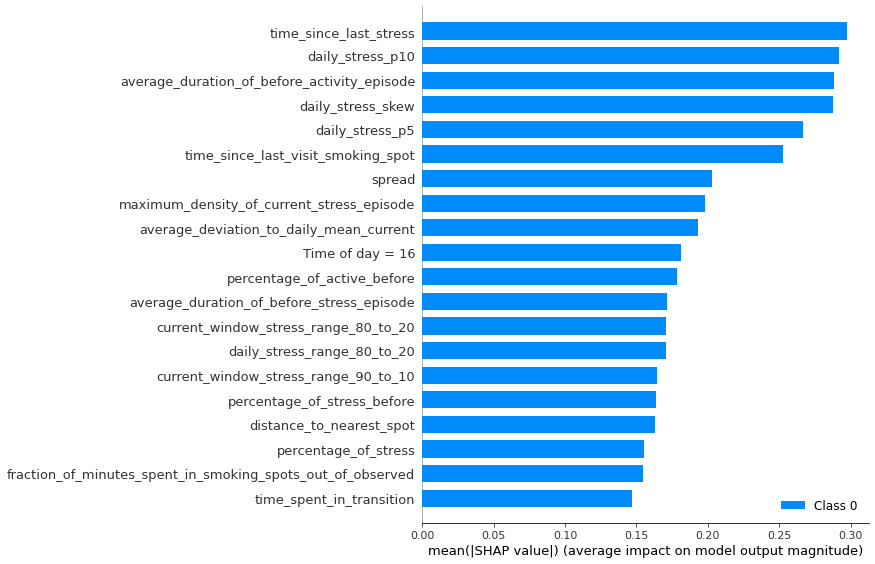

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.30492196878751504 AUC 0.6334350002474869 step 0 stagnant 0
Validation Result now 0.2586027111574557 AUC 0.5724983375334376 step 20 stagnant 0
Validation Result now 0.30265210608424337 AUC 0.6214343051320181 step 40 stagnant 20
Validation Result now 0.3177142857142857 AUC 0.6578323695690069 step 60 stagnant 40
Validation Result now 0.3267605633802817 AUC 0.6535118395596025 step 80 stagnant 0
Validation Result now 0.3532846715328467 AUC 0.6419958960210558 step 100 stagnant 0
Validation Result now 0.3147896879240163 AUC 0.6051025887133046 step 120 stagnant 0
Validation Result now 0.33259423503325936 AUC 0.6361140462822084 step 140 stagnant 20
Validation Result now 0.3062068965517241 AUC 0.642101346974526 step 160 stagnant 40
Validation Result now 0.31660231660231664 AUC 0.6396894254214271 step 180 stagnant 60
Validation Result now 0.2886866059817945 AUC 0.6213046435004552 step 200 stagnant 80
Validation Result now 0.3162393162393163 AUC 0.6117032265839701 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2588055130168453 AUC 0.5887001233130538 step 0 stagnant 0
Validation Result now 0.26068376068376065 AUC 0.5995513492341894 step 20 stagnant 0
Validation Result now 0.2544589774078478 AUC 0.5546978399771021 step 40 stagnant 0
Validation Result now 0.2550655542312276 AUC 0.5253275973753473 step 60 stagnant 20
Validation Result now 0.23337515683814303 AUC 0.5168743046155236 step 80 stagnant 40
Validation Result now 0.23514851485148514 AUC 0.5358826460011492 step 100 stagnant 60
Validation Result now 0.28756476683937826 AUC 0.6466327788908712 step 120 stagnant 80
Validation Result now 0.2801047120418848 AUC 0.6257607533071786 step 140 stagnant 0
Validation Result now 0.2938144329896907 AUC 0.6107579341082185 step 160 stagnant 20
Validation Result now 0.28255528255528256 AUC 0.597029403599536 step 180 stagnant 0
Validation Result now 0.2682926829268293 AUC 0.5597140234703695 step 200 stagnant 20
Validation Result now 0.269179004037685 AUC 0.5506000482061502 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22177954847277556 AUC 0.6012751495143875 step 0 stagnant 0
Validation Result now 0.24069478908188588 AUC 0.6148027313949009 step 20 stagnant 0
Validation Result now 0.25210084033613445 AUC 0.6407025077958384 step 40 stagnant 0
Validation Result now 0.3263403263403264 AUC 0.703131086295465 step 60 stagnant 0
Validation Result now 0.26126126126126126 AUC 0.6240867194208375 step 80 stagnant 0
Validation Result now 0.319327731092437 AUC 0.6025195783683509 step 100 stagnant 20
Validation Result now 0.2809160305343512 AUC 0.530404845578915 step 120 stagnant 40
Validation Result now 0.31301939058171746 AUC 0.5423148851553035 step 140 stagnant 60
Validation Result now 0.29866666666666664 AUC 0.5369428046940738 step 160 stagnant 80
Validation Result now 0.3012912482065997 AUC 0.5565978401923081 step 180 stagnant 100
Validation Result now 0.3047091412742382 AUC 0.5495737844625552 step 200 stagnant 120
Validation Result now 0.27753934191702434 AUC 0.5520271331759461 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.28510938602681724 AUC 0.622161163489867 step 0 stagnant 0
Validation Result now 0.36818181818181817 AUC 0.6678017887925005 step 20 stagnant 0
Validation Result now 0.2554945054945055 AUC 0.6189750382528714 step 40 stagnant 0
Validation Result now 0.3000761614623001 AUC 0.6661928547294753 step 60 stagnant 20
Validation Result now 0.31009615384615385 AUC 0.6666975128639403 step 80 stagnant 40
Validation Result now 0.3005050505050505 AUC 0.6472297066096226 step 100 stagnant 60
Validation Result now 0.3013215859030837 AUC 0.6129027311796948 step 120 stagnant 80
Validation Result now 0.3094405594405594 AUC 0.6180426581387691 step 140 stagnant 100
Validation Result now 0.31157528285465624 AUC 0.6188112126644443 step 160 stagnant 120
Validation Result now 0.3055091819699499 AUC 0.6335630478338438 step 180 stagnant 140
Validation Result now 0.3076923076923077 AUC 0.6355311069552436 step 200 stagnant 160
Validation Result now 0.32 AUC 0.6267706075911774 step 220 stagnant

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.20147142048670064 AUC 0.6214961768649216 step 0 stagnant 0
Validation Result now 0.2766917293233083 AUC 0.6372758898231222 step 20 stagnant 0
Validation Result now 0.2522821576763486 AUC 0.6355789902963602 step 40 stagnant 0
Validation Result now 0.23419203747072603 AUC 0.6307868900792173 step 60 stagnant 20
Validation Result now 0.27450980392156865 AUC 0.5457108362691022 step 80 stagnant 40
Validation Result now 0.27380952380952384 AUC 0.6011594762746115 step 100 stagnant 60
Validation Result now 0.28947368421052627 AUC 0.6534281782164155 step 120 stagnant 80
Validation Result now 0.26843657817109146 AUC 0.6062001394535057 step 140 stagnant 0
Validation Result now 0.2674418604651163 AUC 0.5413394638357031 step 160 stagnant 20
Validation Result now 0.2606232294617564 AUC 0.5480638451721755 step 180 stagnant 40
Validation Result now 0.3450381679389313 AUC 0.6169402652629495 step 200 stagnant 60
Validation Result now 0.29968454258675076 AUC 0.6049627047954359 step

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2977824709609292 AUC 0.6396342788768828 step 0 stagnant 0
Validation Result now 0.23872180451127822 AUC 0.58613190838249 step 20 stagnant 0
Validation Result now 0.28075970272502065 AUC 0.6337704526428376 step 40 stagnant 20
Validation Result now 0.25 AUC 0.6134125004573128 step 60 stagnant 40
Validation Result now 0.25673940949935814 AUC 0.6335643928715154 step 80 stagnant 60
Validation Result now 0.2916006339144216 AUC 0.6193094146180846 step 100 stagnant 80
Validation Result now 0.26158599382080333 AUC 0.5874016239446834 step 120 stagnant 100
Validation Result now 0.2890322580645161 AUC 0.6243363584127264 step 140 stagnant 120
Validation Result now 0.25870646766169153 AUC 0.5991147500059182 step 160 stagnant 140
Validation Result now 0.2761627906976744 AUC 0.626154580337486 step 180 stagnant 160
Validation Result now 0.2970588235294118 AUC 0.5775277023958888 step 200 stagnant 180
Validation Result now 0.2853470437017995 AUC 0.5759012828431299 step 220 stagnan

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2800875273522976 AUC 0.5617977558315453 step 0 stagnant 0
Validation Result now 0.20820189274447948 AUC 0.5150636149017261 step 20 stagnant 0
Validation Result now 0.2806183115338883 AUC 0.5623201684632784 step 40 stagnant 20
Validation Result now 0.2826603325415677 AUC 0.5467648077887366 step 60 stagnant 0
Validation Result now 0.2558425584255843 AUC 0.5818210626443225 step 80 stagnant 0
Validation Result now 0.31065468549422337 AUC 0.57818811589275 step 100 stagnant 20
Validation Result now 0.2765100671140939 AUC 0.5771327993354438 step 120 stagnant 0
Validation Result now 0.27007299270072993 AUC 0.6014144954171876 step 140 stagnant 20
Validation Result now 0.2624113475177305 AUC 0.5539720576493906 step 160 stagnant 40
Validation Result now 0.2819277108433735 AUC 0.5967162788295375 step 180 stagnant 60
Validation Result now 0.2890995260663507 AUC 0.6139889836034527 step 200 stagnant 80
Validation Result now 0.28116710875331563 AUC 0.623412048524655 step 220 st

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


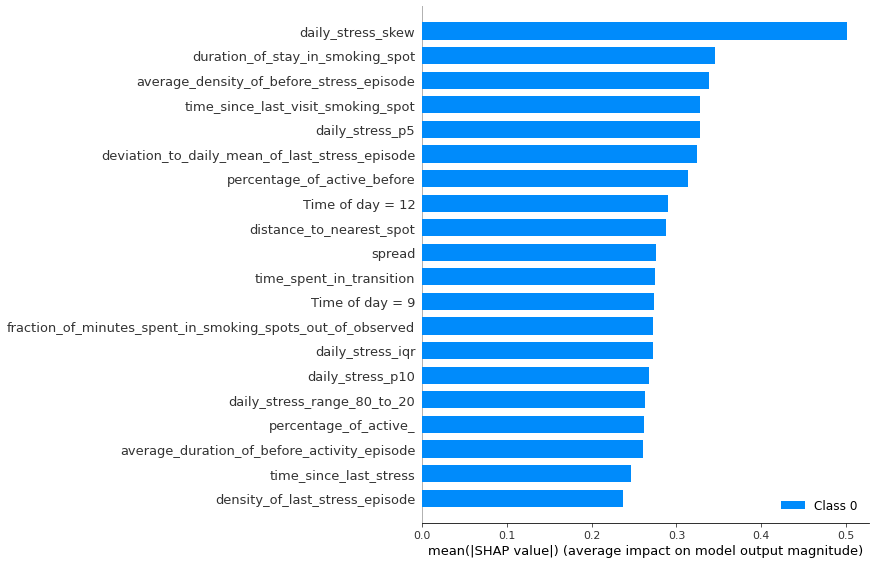

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24071462153267512 AUC 0.5892422797437694 step 0 stagnant 0
Validation Result now 0.2179310344827586 AUC 0.5366626718542963 step 20 stagnant 0
Validation Result now 0.2513043478260869 AUC 0.6077756772191605 step 40 stagnant 20
Validation Result now 0.24209078404401652 AUC 0.5801743369877427 step 60 stagnant 0
Validation Result now 0.24894514767932488 AUC 0.622874239368032 step 80 stagnant 20
Validation Result now 0.23634735899731424 AUC 0.5989250578825807 step 100 stagnant 40
Validation Result now 0.25542168674698795 AUC 0.6138202221903387 step 120 stagnant 60
Validation Result now 0.2670299727520436 AUC 0.6012552713237177 step 140 stagnant 0
Validation Result now 0.25507246376811593 AUC 0.6084540920100938 step 160 stagnant 0
Validation Result now 0.2694915254237288 AUC 0.615542774031469 step 180 stagnant 20
Validation Result now 0.2310030395136778 AUC 0.5741085519930457 step 200 stagnant 0
Validation Result now 0.22630418809698752 AUC 0.5462108360692172 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.250351617440225 AUC 0.514019822146452 step 0 stagnant 0
Validation Result now 0.24620573355817876 AUC 0.5010864764348268 step 20 stagnant 0
Validation Result now 0.20882971268395234 AUC 0.498039869352756 step 40 stagnant 20
Validation Result now 0.2518796992481203 AUC 0.560493696917524 step 60 stagnant 40
Validation Result now 0.21942446043165467 AUC 0.5276003555945659 step 80 stagnant 0
Validation Result now 0.24297752808988762 AUC 0.6161214591755495 step 100 stagnant 20
Validation Result now 0.2396135265700483 AUC 0.5325547669083246 step 120 stagnant 40
Validation Result now 0.2570342205323194 AUC 0.5557746138113604 step 140 stagnant 60
Validation Result now 0.24293785310734461 AUC 0.5585760463173175 step 160 stagnant 0
Validation Result now 0.21366849960722703 AUC 0.5535233119807799 step 180 stagnant 20
Validation Result now 0.2467432950191571 AUC 0.5663830912533302 step 200 stagnant 40
Validation Result now 0.2496532593619972 AUC 0.5923625939273225 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.27714457108578283 AUC 0.5836461665274109 step 0 stagnant 0
Validation Result now 0.24409068982151474 AUC 0.5885173056959835 step 20 stagnant 0
Validation Result now 0.250936329588015 AUC 0.5945088209395686 step 40 stagnant 20
Validation Result now 0.25833838690115224 AUC 0.599557335403884 step 60 stagnant 40
Validation Result now 0.2610188895248998 AUC 0.5707313882535636 step 80 stagnant 60
Validation Result now 0.28864569083447333 AUC 0.5939523604558588 step 100 stagnant 80
Validation Result now 0.2947761194029851 AUC 0.6105433507473393 step 120 stagnant 0
Validation Result now 0.31905465288035445 AUC 0.6113333108273482 step 140 stagnant 0
Validation Result now 0.28298887122416533 AUC 0.5973440124233038 step 160 stagnant 0
Validation Result now 0.2601880877742947 AUC 0.5614133477371639 step 180 stagnant 20
Validation Result now 0.2873469387755102 AUC 0.5951482722436499 step 200 stagnant 40
Validation Result now 0.22467263955892489 AUC 0.5653186988164666 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2378282679256418 AUC 0.562892694275884 step 0 stagnant 0
Validation Result now 0.21035598705501615 AUC 0.6002568495559288 step 20 stagnant 0
Validation Result now 0.214527027027027 AUC 0.5424063399360267 step 40 stagnant 20
Validation Result now 0.21291696238466995 AUC 0.5604882110836351 step 60 stagnant 40
Validation Result now 0.20900594732370434 AUC 0.5393870213609931 step 80 stagnant 60
Validation Result now 0.21408045977011492 AUC 0.5484231744129455 step 100 stagnant 80
Validation Result now 0.24512099921935984 AUC 0.5673923440264895 step 120 stagnant 100
Validation Result now 0.24048096192384766 AUC 0.6049791678974628 step 140 stagnant 0
Validation Result now 0.21190320470896007 AUC 0.5744898877795314 step 160 stagnant 20
Validation Result now 0.24469589816124473 AUC 0.5458738089410653 step 180 stagnant 40
Validation Result now 0.23786407766990292 AUC 0.5623660542225448 step 200 stagnant 60
Validation Result now 0.2717536813922356 AUC 0.5920801438132454 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.23564954682779454 AUC 0.5754895755089869 step 0 stagnant 0
Validation Result now 0.21840148698884757 AUC 0.5869430120322623 step 20 stagnant 0
Validation Result now 0.23529411764705882 AUC 0.571746126860612 step 40 stagnant 20
Validation Result now 0.21325648414985593 AUC 0.5641386818807126 step 60 stagnant 40
Validation Result now 0.23416117587430307 AUC 0.5614229127808676 step 80 stagnant 60
Validation Result now 0.2746515229736706 AUC 0.6100091149240001 step 100 stagnant 80
Validation Result now 0.2555205047318612 AUC 0.5918033201954644 step 120 stagnant 0
Validation Result now 0.26737967914438504 AUC 0.5861657115689203 step 140 stagnant 20
Validation Result now 0.2630651790957134 AUC 0.5841917960057503 step 160 stagnant 40
Validation Result now 0.23371104815864024 AUC 0.5902277605700766 step 180 stagnant 60
Validation Result now 0.21264689423615 AUC 0.5532362200072583 step 200 stagnant 80
Validation Result now 0.23536036036036034 AUC 0.6258581110163983 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22479185938945423 AUC 0.5243728566565671 step 0 stagnant 0
Validation Result now 0.2744360902255639 AUC 0.5719108425396879 step 20 stagnant 0
Validation Result now 0.25106990014265335 AUC 0.5580686770137934 step 40 stagnant 0
Validation Result now 0.26370370370370366 AUC 0.5722392892609879 step 60 stagnant 20
Validation Result now 0.23728813559322032 AUC 0.5947929590025347 step 80 stagnant 40
Validation Result now 0.24213836477987424 AUC 0.5967952883720014 step 100 stagnant 60
Validation Result now 0.21884498480243159 AUC 0.6207119768413412 step 120 stagnant 80
Validation Result now 0.24007060900264782 AUC 0.6208799277557875 step 140 stagnant 100
Validation Result now 0.24893314366998578 AUC 0.5831122120288864 step 160 stagnant 120
Validation Result now 0.2561065877128053 AUC 0.5900090305265556 step 180 stagnant 140
Validation Result now 0.23850350740452064 AUC 0.5749452119923142 step 200 stagnant 160
Validation Result now 0.2211253701875617 AUC 0.56440579979238

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2604904632152588 AUC 0.5824298586905455 step 0 stagnant 0
Validation Result now 0.23228556206712841 AUC 0.6494464934268457 step 20 stagnant 0
Validation Result now 0.24505424377791957 AUC 0.5879556407031995 step 40 stagnant 20
Validation Result now 0.2029881504379186 AUC 0.5608595598391948 step 60 stagnant 40
Validation Result now 0.24023581429624172 AUC 0.570772743001342 step 80 stagnant 60
Validation Result now 0.23624358033749082 AUC 0.5940142519151187 step 100 stagnant 80
Validation Result now 0.23781009409751924 AUC 0.5767627109584454 step 120 stagnant 100
Validation Result now 0.2578664620107445 AUC 0.5736729205173001 step 140 stagnant 120
Validation Result now 0.26239999999999997 AUC 0.5678997133300137 step 160 stagnant 140
Validation Result now 0.2689419795221843 AUC 0.5936715982906704 step 180 stagnant 0
Validation Result now 0.265519360786724 AUC 0.6124501703421754 step 200 stagnant 0
Validation Result now 0.26128590971272225 AUC 0.6154149119031342 ste

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


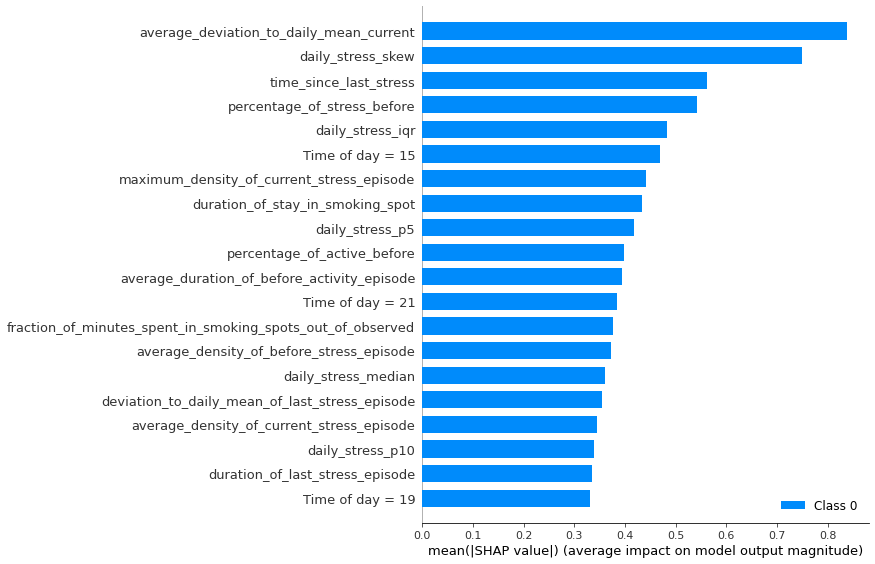

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24578651685393255 AUC 0.56308901071309 step 0 stagnant 0
Validation Result now 0.2887077997671711 AUC 0.594406386006026 step 20 stagnant 0
Validation Result now 0.261808367071525 AUC 0.5626447941078004 step 40 stagnant 0
Validation Result now 0.3114119922630561 AUC 0.5752366504854369 step 60 stagnant 20
Validation Result now 0.28867924528301886 AUC 0.5220126799464346 step 80 stagnant 0
Validation Result now 0.26149684400360684 AUC 0.5085296702376967 step 100 stagnant 20
Validation Result now 0.2920962199312715 AUC 0.5416965182457315 step 120 stagnant 40
Validation Result now 0.28298611111111116 AUC 0.5749010294609975 step 140 stagnant 60
Validation Result now 0.27314390467461047 AUC 0.5400136006026113 step 160 stagnant 80
Validation Result now 0.3025962399283796 AUC 0.5773493471710747 step 180 stagnant 100
Validation Result now 0.3109090909090909 AUC 0.5794047120857047 step 200 stagnant 120
Validation Result now 0.28256880733944956 AUC 0.5642915132239705 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2343612334801762 AUC 0.5042201623702711 step 0 stagnant 0
Validation Result now 0.23269809428284854 AUC 0.4712554402410445 step 20 stagnant 0
Validation Result now 0.26380368098159507 AUC 0.5704345915634416 step 40 stagnant 20
Validation Result now 0.25 AUC 0.6065669986608637 step 60 stagnant 0
Validation Result now 0.2737430167597765 AUC 0.5812648560428524 step 80 stagnant 20
Validation Result now 0.2629193109700816 AUC 0.6126186391027787 step 100 stagnant 0
Validation Result now 0.26590909090909093 AUC 0.5846955557415466 step 120 stagnant 20
Validation Result now 0.29511278195488716 AUC 0.6181423669233345 step 140 stagnant 40
Validation Result now 0.27516158818097874 AUC 0.6073225644459324 step 160 stagnant 0
Validation Result now 0.24061433447098976 AUC 0.602272974556411 step 180 stagnant 20
Validation Result now 0.2488584474885845 AUC 0.5771451288918648 step 200 stagnant 40
Validation Result now 0.27479338842975204 AUC 0.5972212922664881 step 220 stagnant 60

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.27945205479452057 AUC 0.6383511884834282 step 0 stagnant 0
Validation Result now 0.2695852534562212 AUC 0.5939104871108134 step 20 stagnant 0
Validation Result now 0.26645004061738425 AUC 0.6280875460328088 step 40 stagnant 20
Validation Result now 0.25948103792415167 AUC 0.5879709993304318 step 60 stagnant 40
Validation Result now 0.35850956696878145 AUC 0.6408214763977235 step 80 stagnant 60
Validation Result now 0.2818930041152264 AUC 0.5985254854368931 step 100 stagnant 0
Validation Result now 0.33930453108535297 AUC 0.6388728239035821 step 120 stagnant 20
Validation Result now 0.3239625167336011 AUC 0.6515990123870103 step 140 stagnant 40
Validation Result now 0.3273657289002557 AUC 0.6688575493806495 step 160 stagnant 60
Validation Result now 0.31220657276995306 AUC 0.6484394877803816 step 180 stagnant 80
Validation Result now 0.3492462311557789 AUC 0.6308819467693337 step 200 stagnant 100
Validation Result now 0.3361144219308701 AUC 0.6196612403749582 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.25409836065573765 AUC 0.638172079009039 step 0 stagnant 0
Validation Result now 0.2454361054766734 AUC 0.6208911533311015 step 20 stagnant 0
Validation Result now 0.28802153432032307 AUC 0.6240008788081687 step 40 stagnant 20
Validation Result now 0.3087934560327198 AUC 0.6886776029460998 step 60 stagnant 0
Validation Result now 0.28517110266159695 AUC 0.6764479410780047 step 80 stagnant 0
Validation Result now 0.24757281553398056 AUC 0.5915868764646803 step 100 stagnant 20
Validation Result now 0.2438095238095238 AUC 0.5622842735185805 step 120 stagnant 40
Validation Result now 0.26302729528535973 AUC 0.540807666555072 step 140 stagnant 60
Validation Result now 0.2545454545454546 AUC 0.530409691998661 step 160 stagnant 80
Validation Result now 0.2594059405940594 AUC 0.5460742383662538 step 180 stagnant 100
Validation Result now 0.25072886297376096 AUC 0.5768967609641782 step 200 stagnant 120
Validation Result now 0.28506271379703535 AUC 0.5638213508536993 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2690854119425548 AUC 0.6203916973552059 step 0 stagnant 0
Validation Result now 0.287317620650954 AUC 0.6265345664546368 step 20 stagnant 0
Validation Result now 0.3023758099352052 AUC 0.5842143036491463 step 40 stagnant 0
Validation Result now 0.33121019108280253 AUC 0.6429078088382992 step 60 stagnant 0
Validation Result now 0.31789737171464333 AUC 0.6149679862738534 step 80 stagnant 0
Validation Result now 0.29802955665024633 AUC 0.5725730247740207 step 100 stagnant 20
Validation Result now 0.3492822966507177 AUC 0.6323204720455307 step 120 stagnant 40
Validation Result now 0.32086614173228345 AUC 0.6413939571476399 step 140 stagnant 0
Validation Result now 0.32763532763532766 AUC 0.5962759457649817 step 160 stagnant 20
Validation Result now 0.3314763231197771 AUC 0.6114935554067625 step 180 stagnant 40
Validation Result now 0.3559539052496799 AUC 0.6276305657850686 step 200 stagnant 60
Validation Result now 0.34178905206942595 AUC 0.6212353531971877 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.23272214386459802 AUC 0.6182635169065953 step 0 stagnant 0
Validation Result now 0.2812089356110381 AUC 0.6420639437562772 step 20 stagnant 0
Validation Result now 0.2907180385288967 AUC 0.6553517325075328 step 40 stagnant 0
Validation Result now 0.24535315985130116 AUC 0.6673562520924003 step 60 stagnant 0
Validation Result now 0.31070195627157654 AUC 0.5875602611315701 step 80 stagnant 20
Validation Result now 0.2844574780058651 AUC 0.6143883913625712 step 100 stagnant 0
Validation Result now 0.27533039647577096 AUC 0.5885980917308337 step 120 stagnant 20
Validation Result now 0.26119402985074625 AUC 0.5899725895547373 step 140 stagnant 40
Validation Result now 0.2665066026410564 AUC 0.5765766237027117 step 160 stagnant 60
Validation Result now 0.25450689289501593 AUC 0.5237627636424507 step 180 stagnant 80
Validation Result now 0.2660217654171705 AUC 0.5289659357214598 step 200 stagnant 100
Validation Result now 0.2812846068660022 AUC 0.5258223133578841 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2655715263518138 AUC 0.6205061516571811 step 0 stagnant 0
Validation Result now 0.3206349206349206 AUC 0.6402385336457984 step 20 stagnant 0
Validation Result now 0.26426426426426425 AUC 0.5790092484097757 step 40 stagnant 0
Validation Result now 0.2497420020639835 AUC 0.6595706394375629 step 60 stagnant 20
Validation Result now 0.2183235867446394 AUC 0.5888874707063944 step 80 stagnant 40
Validation Result now 0.21584158415841587 AUC 0.5913357884164714 step 100 stagnant 60
Validation Result now 0.21923474663908996 AUC 0.5391190994308672 step 120 stagnant 80
Validation Result now 0.22809123649459784 AUC 0.6346631235353197 step 140 stagnant 100
Validation Result now 0.24370860927152316 AUC 0.6354019501171744 step 160 stagnant 120
Validation Result now 0.25999999999999995 AUC 0.5993444509541346 step 180 stagnant 140
Validation Result now 0.26890756302521013 AUC 0.5662636006026114 step 200 stagnant 160
Validation Result now 0.26789366053169733 AUC 0.628340098761298

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


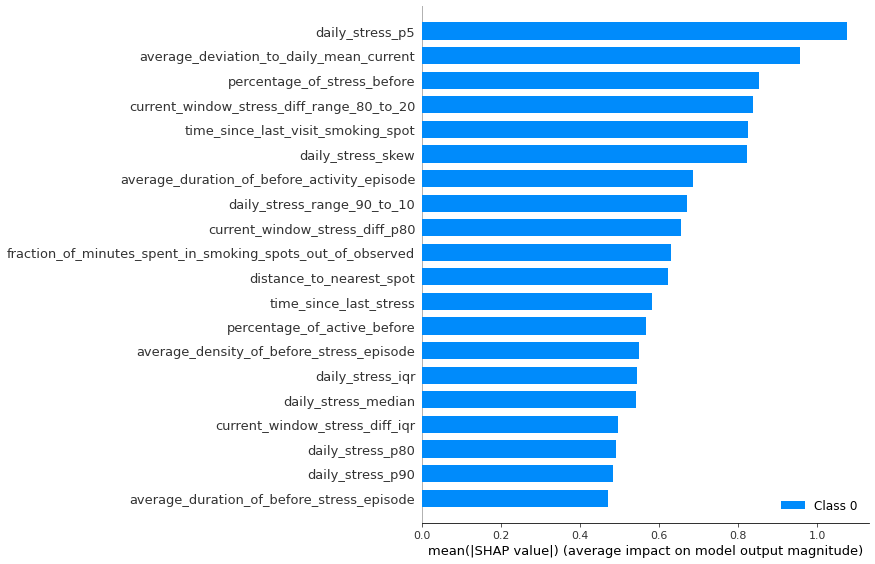

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2607242339832869 AUC 0.5565981361481771 step 0 stagnant 0
Validation Result now 0.24081632653061225 AUC 0.6231875893979499 step 20 stagnant 0
Validation Result now 0.2117974918718068 AUC 0.562902935595509 step 40 stagnant 20
Validation Result now 0.20219360991893182 AUC 0.5623405487228628 step 60 stagnant 40
Validation Result now 0.18854242204496013 AUC 0.5813485234533174 step 80 stagnant 60
Validation Result now 0.21535393818544368 AUC 0.5811004995968065 step 100 stagnant 80
Validation Result now 0.2213066509711595 AUC 0.5692189807168674 step 120 stagnant 100
Validation Result now 0.2235011990407674 AUC 0.588707733804785 step 140 stagnant 120
Validation Result now 0.20987654320987656 AUC 0.565043430999433 step 160 stagnant 140
Validation Result now 0.21217197096594081 AUC 0.5756156026401953 step 180 stagnant 160
Validation Result now 0.19888888888888892 AUC 0.5639413549448363 step 200 stagnant 180
Validation Result now 0.1896125309150866 AUC 0.5574451726964113 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1897681451612903 AUC 0.5183976131933835 step 0 stagnant 0
Validation Result now 0.1983640081799591 AUC 0.5387386645669239 step 20 stagnant 0
Validation Result now 0.22032085561497325 AUC 0.5588131212461114 step 40 stagnant 0
Validation Result now 0.19019807008633824 AUC 0.5499154201507623 step 60 stagnant 0
Validation Result now 0.201 AUC 0.550990568490488 step 80 stagnant 20
Validation Result now 0.18532818532818532 AUC 0.5445838357776682 step 100 stagnant 40
Validation Result now 0.1784651992861392 AUC 0.5631112384933026 step 120 stagnant 60
Validation Result now 0.1515892420537897 AUC 0.5719191805390825 step 140 stagnant 80
Validation Result now 0.18975741239892183 AUC 0.54008711373689 step 160 stagnant 100
Validation Result now 0.17805755395683454 AUC 0.5424354993533222 step 180 stagnant 120
Validation Result now 0.18134263295553618 AUC 0.5844837967376403 step 200 stagnant 140
Validation Result now 0.1911764705882353 AUC 0.6160920849438377 step 220 stagnant 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2291520672740014 AUC 0.5864145448452719 step 0 stagnant 0
Validation Result now 0.29736511919698866 AUC 0.6505704961385038 step 20 stagnant 0
Validation Result now 0.27693807898586054 AUC 0.6649153334868523 step 40 stagnant 0
Validation Result now 0.2657952069716776 AUC 0.6144628034371732 step 60 stagnant 20
Validation Result now 0.2818043588443994 AUC 0.6334961583126785 step 80 stagnant 40
Validation Result now 0.25034137460172967 AUC 0.5887292966109459 step 100 stagnant 60
Validation Result now 0.24739195230998506 AUC 0.611846585070532 step 120 stagnant 80
Validation Result now 0.24815119145439604 AUC 0.6030027394049243 step 140 stagnant 100
Validation Result now 0.23056768558951968 AUC 0.6154011466047968 step 160 stagnant 120
Validation Result now 0.2962382445141066 AUC 0.6596809364984644 step 180 stagnant 140
Validation Result now 0.27759197324414714 AUC 0.6533697404292091 step 200 stagnant 160
Validation Result now 0.29256594724220625 AUC 0.654284147850281 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1843575418994413 AUC 0.5125324267462984 step 0 stagnant 0
Validation Result now 0.24655172413793106 AUC 0.5859010611789428 step 20 stagnant 0
Validation Result now 0.24561403508771928 AUC 0.5929774789386064 step 40 stagnant 0
Validation Result now 0.24720893141945777 AUC 0.5473024000950827 step 60 stagnant 20
Validation Result now 0.2590120160213618 AUC 0.5806614024531664 step 80 stagnant 0
Validation Result now 0.25 AUC 0.621491556046376 step 100 stagnant 0
Validation Result now 0.2493112947658402 AUC 0.6116604640068275 step 120 stagnant 20
Validation Result now 0.276100086281277 AUC 0.5785789925031593 step 140 stagnant 40
Validation Result now 0.2758100979653354 AUC 0.5649086892537577 step 160 stagnant 0
Validation Result now 0.26697530864197533 AUC 0.5787120835076929 step 180 stagnant 20
Validation Result now 0.2548877624909486 AUC 0.552890571544359 step 200 stagnant 40
Validation Result now 0.2538616521155137 AUC 0.5550587168624033 step 220 stagnant 60
Valid

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22398123717384932 AUC 0.5999142027291704 step 0 stagnant 0
Validation Result now 0.2465331278890601 AUC 0.5792928348755382 step 20 stagnant 0
Validation Result now 0.25602660016625106 AUC 0.573101627053006 step 40 stagnant 0
Validation Result now 0.2815033161385409 AUC 0.5955777057504392 step 60 stagnant 0
Validation Result now 0.23865300146412885 AUC 0.5681335152450071 step 80 stagnant 0
Validation Result now 0.23861566484517308 AUC 0.5367063958790899 step 100 stagnant 20
Validation Result now 0.18774703557312253 AUC 0.564978639409629 step 120 stagnant 40
Validation Result now 0.1920600858369099 AUC 0.5839791858049468 step 140 stagnant 60
Validation Result now 0.21554116558741906 AUC 0.5606772206801549 step 160 stagnant 80
Validation Result now 0.2001156737998843 AUC 0.5841479740866655 step 180 stagnant 100
Validation Result now 0.1961206896551724 AUC 0.571191410038322 step 200 stagnant 120
Validation Result now 0.21160409556313992 AUC 0.5921786233974399 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2328502415458937 AUC 0.5924035368779699 step 0 stagnant 0
Validation Result now 0.22627037392138064 AUC 0.5995130726317848 step 20 stagnant 0
Validation Result now 0.23487544483985764 AUC 0.5517243229278866 step 40 stagnant 20
Validation Result now 0.2025469981807156 AUC 0.5415439959655887 step 60 stagnant 0
Validation Result now 0.19922254616132165 AUC 0.5597676623111862 step 80 stagnant 20
Validation Result now 0.2139673105497771 AUC 0.5223133775236737 step 100 stagnant 40
Validation Result now 0.20425531914893616 AUC 0.5356149464705917 step 120 stagnant 60
Validation Result now 0.215 AUC 0.517000157645779 step 140 stagnant 80
Validation Result now 0.20363062352012629 AUC 0.5282248878940423 step 160 stagnant 100
Validation Result now 0.19829589465530598 AUC 0.4966006081330365 step 180 stagnant 120
Validation Result now 0.19778481012658225 AUC 0.4959403116764349 step 200 stagnant 140
Validation Result now 0.19222903885480572 AUC 0.5252456096475915 step 220 stag

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21527213647441104 AUC 0.5896050147865137 step 0 stagnant 0
Validation Result now 0.20673076923076925 AUC 0.5739045062757051 step 20 stagnant 0
Validation Result now 0.24794745484400654 AUC 0.5484812356127593 step 40 stagnant 20
Validation Result now 0.21935483870967742 AUC 0.5795918253647931 step 60 stagnant 0
Validation Result now 0.22222222222222224 AUC 0.5991945827627959 step 80 stagnant 20
Validation Result now 0.24096385542168677 AUC 0.5985496588330745 step 100 stagnant 40
Validation Result now 0.21946902654867254 AUC 0.6054731766945064 step 120 stagnant 60
Validation Result now 0.2222222222222222 AUC 0.6012310814748052 step 140 stagnant 80
Validation Result now 0.2350282485875706 AUC 0.6410439658395628 step 160 stagnant 100
Validation Result now 0.24608967674661109 AUC 0.6435804327748051 step 180 stagnant 120
Validation Result now 0.22026887280248192 AUC 0.5939414085939234 step 200 stagnant 140
Validation Result now 0.22445561139028478 AUC 0.57548467823340

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.


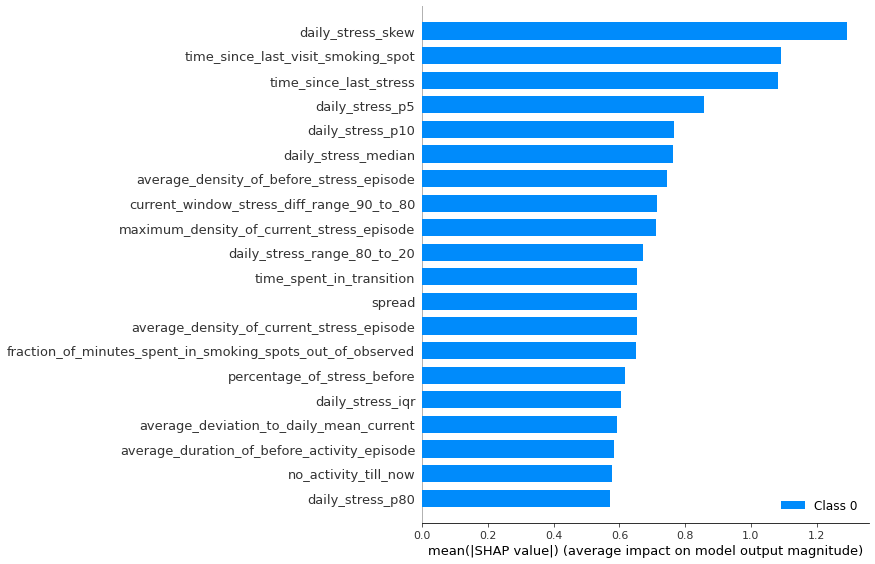

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.14538310412573674 AUC 0.5162931250821572 step 0 stagnant 0
Validation Result now 0.21666666666666667 AUC 0.5454822480610891 step 20 stagnant 0
Validation Result now 0.1964573268921095 AUC 0.5599440135753636 step 40 stagnant 0
Validation Result now 0.22031473533619456 AUC 0.5848092757017722 step 60 stagnant 20
Validation Result now 0.21800947867298578 AUC 0.5553530670044574 step 80 stagnant 0
Validation Result now 0.25865209471766853 AUC 0.6232394450353127 step 100 stagnant 20
Validation Result now 0.2096774193548387 AUC 0.5249737096832017 step 120 stagnant 0
Validation Result now 0.2032258064516129 AUC 0.5498666065176087 step 140 stagnant 20
Validation Result now 0.21934369602763384 AUC 0.5226329752273515 step 160 stagnant 40
Validation Result now 0.2214472537053182 AUC 0.5224135407081656 step 180 stagnant 60
Validation Result now 0.21015761821366025 AUC 0.5307460773652322 step 200 stagnant 80
Validation Result now 0.20853858784893267 AUC 0.5257725768095505 step

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1607875307629204 AUC 0.5745079528208314 step 0 stagnant 0
Validation Result now 0.1920374707259953 AUC 0.5927623952868633 step 20 stagnant 0
Validation Result now 0.219735503560529 AUC 0.5985730034296913 step 40 stagnant 0
Validation Result now 0.21647819063004847 AUC 0.6159102723437817 step 60 stagnant 0
Validation Result now 0.22275258552108196 AUC 0.6124511537864031 step 80 stagnant 20
Validation Result now 0.2222222222222222 AUC 0.6084396398226598 step 100 stagnant 0
Validation Result now 0.20886075949367086 AUC 0.579139679258135 step 120 stagnant 20
Validation Result now 0.22313203684749233 AUC 0.5723427361049701 step 140 stagnant 40
Validation Result now 0.22313203684749233 AUC 0.5538029839509566 step 160 stagnant 0
Validation Result now 0.2182182182182182 AUC 0.5499262078608047 step 180 stagnant 0
Validation Result now 0.20722433460076045 AUC 0.576452988133507 step 200 stagnant 20
Validation Result now 0.20000000000000004 AUC 0.5887029313703229 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.195906432748538 AUC 0.6115731169560593 step 0 stagnant 0
Validation Result now 0.19731800766283525 AUC 0.6232605071641113 step 20 stagnant 0
Validation Result now 0.22368421052631582 AUC 0.6007903526487495 step 40 stagnant 0
Validation Result now 0.2179616548940464 AUC 0.6096198659193843 step 60 stagnant 0
Validation Result now 0.2376237623762376 AUC 0.6254977234975682 step 80 stagnant 20
Validation Result now 0.19109663409337677 AUC 0.5284104217205818 step 100 stagnant 0
Validation Result now 0.18783542039355994 AUC 0.5673248706396912 step 120 stagnant 20
Validation Result now 0.18617511520737326 AUC 0.5681430073732389 step 140 stagnant 40
Validation Result now 0.21699078812691916 AUC 0.5823683094131284 step 160 stagnant 60
Validation Result now 0.20710659898477157 AUC 0.5927761379524623 step 180 stagnant 80
Validation Result now 0.18445121951219512 AUC 0.5799784299900813 step 200 stagnant 100
Validation Result now 0.20481927710843373 AUC 0.5659382058053799 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.152014652014652 AUC 0.45506133411407607 step 0 stagnant 0
Validation Result now 0.19946571682991987 AUC 0.5902761678278223 step 20 stagnant 0
Validation Result now 0.1996370235934664 AUC 0.5511542345335261 step 40 stagnant 0
Validation Result now 0.19733333333333333 AUC 0.5934302589596204 step 60 stagnant 0
Validation Result now 0.209188660801564 AUC 0.5396900132646598 step 80 stagnant 20
Validation Result now 0.19133937562940584 AUC 0.5275827248718348 step 100 stagnant 0
Validation Result now 0.19180819180819178 AUC 0.5695386348155496 step 120 stagnant 20
Validation Result now 0.19348054679284965 AUC 0.5494737455336336 step 140 stagnant 40
Validation Result now 0.19935691318327975 AUC 0.5210890166226503 step 160 stagnant 60
Validation Result now 0.19117647058823534 AUC 0.5187945889747971 step 180 stagnant 80
Validation Result now 0.1784386617100372 AUC 0.5481165079289205 step 200 stagnant 100
Validation Result now 0.17652411282984531 AUC 0.48348176408025717 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.16495402920497568 AUC 0.5468574108818012 step 0 stagnant 0
Validation Result now 0.16352201257861637 AUC 0.5286633166429655 step 20 stagnant 0
Validation Result now 0.1565059144676979 AUC 0.5451352457547114 step 40 stagnant 20
Validation Result now 0.15520628683693516 AUC 0.5164634146341462 step 60 stagnant 40
Validation Result now 0.16537467700258396 AUC 0.5508483108471457 step 80 stagnant 60
Validation Result now 0.15671641791044777 AUC 0.5531348215245994 step 100 stagnant 0
Validation Result now 0.1707097933513028 AUC 0.583109218341081 step 120 stagnant 20
Validation Result now 0.15695415695415696 AUC 0.5812188549372019 step 140 stagnant 0
Validation Result now 0.16545454545454547 AUC 0.5367362364216488 step 160 stagnant 20
Validation Result now 0.15907059874888294 AUC 0.5432229239612337 step 180 stagnant 40
Validation Result now 0.1543357199681782 AUC 0.5550641722732759 step 200 stagnant 60
Validation Result now 0.1644479248238058 AUC 0.5795495691973088 step

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.20594059405940596 AUC 0.5894483216022754 step 0 stagnant 0
Validation Result now 0.22357019064124786 AUC 0.5794349971917161 step 20 stagnant 0
Validation Result now 0.23672566371681414 AUC 0.6421509960445023 step 40 stagnant 0
Validation Result now 0.2501861504095309 AUC 0.653890966886151 step 60 stagnant 0
Validation Result now 0.21760000000000002 AUC 0.5939895256987846 step 80 stagnant 0
Validation Result now 0.22429906542056072 AUC 0.6070190664547508 step 100 stagnant 20
Validation Result now 0.23255813953488372 AUC 0.6181928992244357 step 120 stagnant 40
Validation Result now 0.2469135802469136 AUC 0.5973309353377708 step 140 stagnant 60
Validation Result now 0.2389705882352941 AUC 0.5888766565887118 step 160 stagnant 80
Validation Result now 0.2356115107913669 AUC 0.561187276681684 step 180 stagnant 100
Validation Result now 0.2089864158829676 AUC 0.5757146186111544 step 200 stagnant 120
Validation Result now 0.216076058772688 AUC 0.5748022251168127 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1714785651793526 AUC 0.5402001350366272 step 0 stagnant 0
Validation Result now 0.18155410312273057 AUC 0.5854166417705333 step 20 stagnant 0
Validation Result now 0.22453987730061348 AUC 0.6238759395800719 step 40 stagnant 0
Validation Result now 0.21551132463967057 AUC 0.6301036077484734 step 60 stagnant 0
Validation Result now 0.2033898305084746 AUC 0.5902498775110241 step 80 stagnant 20
Validation Result now 0.24278606965174127 AUC 0.5439647291499863 step 100 stagnant 40
Validation Result now 0.27187500000000003 AUC 0.5961683357034452 step 120 stagnant 0
Validation Result now 0.22533022533022534 AUC 0.6052419306652645 step 140 stagnant 0
Validation Result now 0.2329450915141431 AUC 0.6116806682520525 step 160 stagnant 20
Validation Result now 0.20606060606060606 AUC 0.5785672673605717 step 180 stagnant 40
Validation Result now 0.22290388548057258 AUC 0.5938721155339921 step 200 stagnant 60
Validation Result now 0.22625400213447172 AUC 0.5900982600590337 step

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


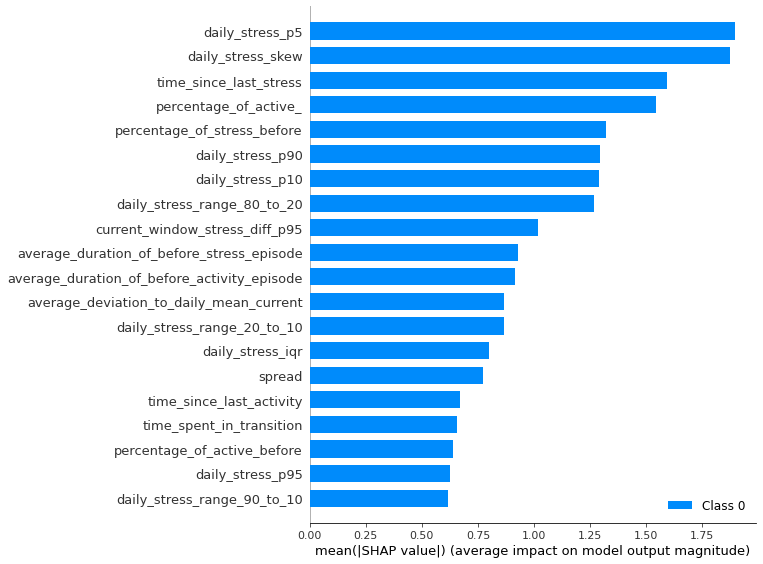

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21534653465346532 AUC 0.5220760513202323 step 0 stagnant 0
Validation Result now 0.22013422818791947 AUC 0.6037909327507723 step 20 stagnant 0
Validation Result now 0.23762376237623764 AUC 0.5967821992332661 step 40 stagnant 0
Validation Result now 0.2592047128129602 AUC 0.623494002951991 step 60 stagnant 0
Validation Result now 0.27586206896551724 AUC 0.5571854366268932 step 80 stagnant 0
Validation Result now 0.27426810477657937 AUC 0.6114060244780135 step 100 stagnant 0
Validation Result now 0.2716763005780347 AUC 0.5890428152981054 step 120 stagnant 20
Validation Result now 0.28658536585365857 AUC 0.5210368133518812 step 140 stagnant 40
Validation Result now 0.2890756302521008 AUC 0.6481544750093067 step 160 stagnant 0
Validation Result now 0.2761627906976744 AUC 0.5770017780520778 step 180 stagnant 0
Validation Result now 0.2844702467343977 AUC 0.5953592677494988 step 200 stagnant 20
Validation Result now 0.2729970326409496 AUC 0.6471021751340478 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2798165137614678 AUC 0.6760759337630701 step 0 stagnant 0
Validation Result now 0.2611534276387378 AUC 0.640241204438436 step 20 stagnant 0
Validation Result now 0.2486338797814208 AUC 0.5739475368509048 step 40 stagnant 20
Validation Result now 0.24113475177304966 AUC 0.6291383794745194 step 60 stagnant 40
Validation Result now 0.26861702127659576 AUC 0.6564247030048918 step 80 stagnant 60
Validation Result now 0.26336375488917857 AUC 0.636684896190495 step 100 stagnant 80
Validation Result now 0.2781641168289291 AUC 0.6782707423081696 step 120 stagnant 100
Validation Result now 0.27400768245838675 AUC 0.6631454622935402 step 140 stagnant 120
Validation Result now 0.2835633626097867 AUC 0.6562928593820412 step 160 stagnant 140
Validation Result now 0.27259684361549497 AUC 0.6425219358399132 step 180 stagnant 0
Validation Result now 0.32183908045977005 AUC 0.6902189175597745 step 200 stagnant 20
Validation Result now 0.2921348314606741 AUC 0.6588831987956922 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1921641791044776 AUC 0.5847101399583324 step 0 stagnant 0
Validation Result now 0.264765784114053 AUC 0.6632344465343496 step 20 stagnant 0
Validation Result now 0.276797829036635 AUC 0.5812024056767048 step 40 stagnant 0
Validation Result now 0.28740740740740744 AUC 0.5876539672276756 step 60 stagnant 0
Validation Result now 0.2504012841091493 AUC 0.6148211008575141 step 80 stagnant 0
Validation Result now 0.290519877675841 AUC 0.6168230421834284 step 100 stagnant 20
Validation Result now 0.3125 AUC 0.6255304358758333 step 120 stagnant 0
Validation Result now 0.30701754385964913 AUC 0.641038388944402 step 140 stagnant 0
Validation Result now 0.3060921248142645 AUC 0.6261404677468864 step 160 stagnant 20
Validation Result now 0.296398891966759 AUC 0.6390046092204001 step 180 stagnant 40
Validation Result now 0.30359937402190923 AUC 0.6367846973229621 step 200 stagnant 60
Validation Result now 0.2938775510204082 AUC 0.6183333251696415 step 220 stagnant 80
Validat

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22841656987998452 AUC 0.7057142169060261 step 0 stagnant 0
Validation Result now 0.2556538839724681 AUC 0.7406505319461588 step 20 stagnant 0
Validation Result now 0.3 AUC 0.6959288077091375 step 40 stagnant 0
Validation Result now 0.26036644165863065 AUC 0.6789507778365563 step 60 stagnant 0
Validation Result now 0.2538593481989709 AUC 0.6973884758060831 step 80 stagnant 20
Validation Result now 0.24970273483947683 AUC 0.6951755030466897 step 100 stagnant 40
Validation Result now 0.28545780969479356 AUC 0.7123602784145457 step 120 stagnant 60
Validation Result now 0.336283185840708 AUC 0.7127266240848502 step 140 stagnant 80
Validation Result now 0.307537688442211 AUC 0.6998686053801995 step 160 stagnant 0
Validation Result now 0.33906633906633904 AUC 0.7200194540776008 step 180 stagnant 20
Validation Result now 0.3451327433628319 AUC 0.7352359633482892 step 200 stagnant 0
Validation Result now 0.3191489361702128 AUC 0.733705883409419 step 220 stagnant 0
Valida

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2974559686888454 AUC 0.6195717572183363 step 0 stagnant 0
Validation Result now 0.2520833333333333 AUC 0.6184192480260193 step 20 stagnant 0
Validation Result now 0.25885978428351314 AUC 0.6480716135373603 step 40 stagnant 20
Validation Result now 0.26109660574412535 AUC 0.636619586655956 step 60 stagnant 40
Validation Result now 0.2542372881355932 AUC 0.6272897114624764 step 80 stagnant 60
Validation Result now 0.2607561929595828 AUC 0.63280959168479 step 100 stagnant 80
Validation Result now 0.27011494252873564 AUC 0.6284116068104783 step 120 stagnant 100
Validation Result now 0.27624309392265195 AUC 0.6275248257868167 step 140 stagnant 120
Validation Result now 0.24929178470254953 AUC 0.633129608404031 step 160 stagnant 140
Validation Result now 0.2154845695722794 AUC 0.6366646910532469 step 180 stagnant 160
Validation Result now 0.25874867444326616 AUC 0.6170065211570237 step 200 stagnant 180
Validation Result now 0.2766169154228856 AUC 0.6761502233586082 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.23155044008124578 AUC 0.632325892944611 step 0 stagnant 0
Validation Result now 0.3037249283667622 AUC 0.675538150564601 step 20 stagnant 0
Validation Result now 0.27065868263473053 AUC 0.6698862226271413 step 40 stagnant 0
Validation Result now 0.24046242774566476 AUC 0.6098367588184199 step 60 stagnant 20
Validation Result now 0.26702269692923897 AUC 0.60119528693744 step 80 stagnant 40
Validation Result now 0.2717557251908397 AUC 0.6297984139579538 step 100 stagnant 60
Validation Result now 0.2968099861303745 AUC 0.6504415332719423 step 120 stagnant 80
Validation Result now 0.25030674846625767 AUC 0.6296433038134237 step 140 stagnant 100
Validation Result now 0.2706766917293233 AUC 0.585468546928166 step 160 stagnant 120
Validation Result now 0.2731411229135053 AUC 0.6175883882913067 step 180 stagnant 140
Validation Result now 0.26220362622036264 AUC 0.6733321169432527 step 200 stagnant 160
Validation Result now 0.28763440860215056 AUC 0.7000100413409354 step

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.18211206896551724 AUC 0.5567780684052065 step 0 stagnant 0
Validation Result now 0.2147197839297772 AUC 0.5995682631582384 step 20 stagnant 0
Validation Result now 0.26259946949602125 AUC 0.5856401885486262 step 40 stagnant 0
Validation Result now 0.26728110599078336 AUC 0.6287193779919931 step 60 stagnant 0
Validation Result now 0.3038277511961723 AUC 0.6388335798768262 step 80 stagnant 0
Validation Result now 0.30622009569377984 AUC 0.6451367663290164 step 100 stagnant 0
Validation Result now 0.34545454545454546 AUC 0.6789852694344847 step 120 stagnant 0
Validation Result now 0.32679738562091504 AUC 0.6881275838084602 step 140 stagnant 0
Validation Result now 0.3193916349809886 AUC 0.6778362298111902 step 160 stagnant 20
Validation Result now 0.30246189917936694 AUC 0.6865913811007269 step 180 stagnant 40
Validation Result now 0.24695977549111317 AUC 0.6316719812300396 step 200 stagnant 60
Validation Result now 0.3038277511961723 AUC 0.6387352073904269 step 22

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


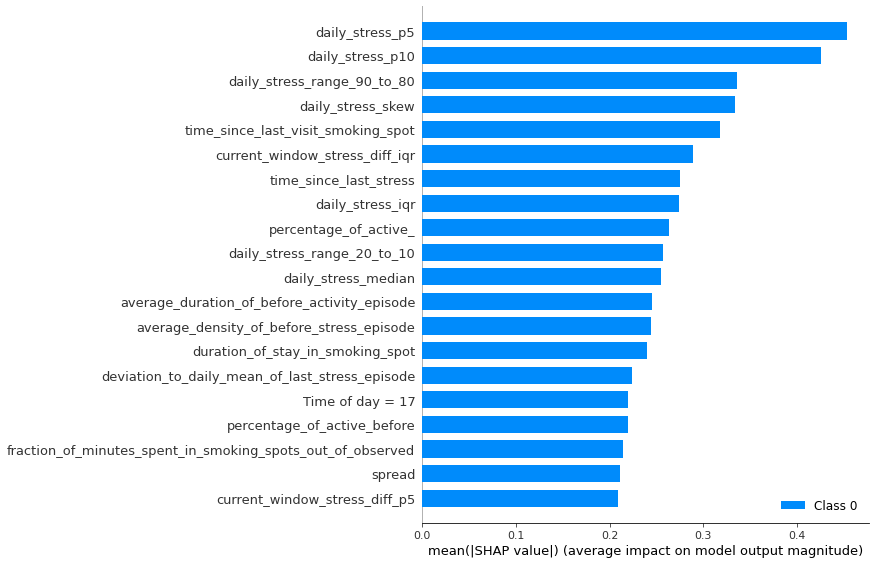

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.30916030534351147 AUC 0.6853221071420184 step 0 stagnant 0
Validation Result now 0.2885572139303483 AUC 0.6566727729631978 step 20 stagnant 0
Validation Result now 0.31042128603104213 AUC 0.716470795462552 step 40 stagnant 20
Validation Result now 0.2912371134020619 AUC 0.6242934310340779 step 60 stagnant 0
Validation Result now 0.26335403726708073 AUC 0.6161518588975786 step 80 stagnant 20
Validation Result now 0.2680151706700379 AUC 0.6209572794100378 step 100 stagnant 40
Validation Result now 0.293558606124604 AUC 0.610864510674276 step 120 stagnant 60
Validation Result now 0.2703703703703704 AUC 0.5859933300453275 step 140 stagnant 80
Validation Result now 0.31707317073170727 AUC 0.5943368796824726 step 160 stagnant 100
Validation Result now 0.2986666666666667 AUC 0.6152805373540948 step 180 stagnant 0
Validation Result now 0.28822882288228824 AUC 0.6439061509194673 step 200 stagnant 20
Validation Result now 0.3086997193638915 AUC 0.6684811761666549 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.32799999999999996 AUC 0.6408504192207427 step 0 stagnant 0
Validation Result now 0.32134831460674157 AUC 0.6899419901829541 step 20 stagnant 0
Validation Result now 0.26716604244694137 AUC 0.6094455013034594 step 40 stagnant 20
Validation Result now 0.2543352601156069 AUC 0.619703844618239 step 60 stagnant 40
Validation Result now 0.26567164179104474 AUC 0.5708887010028418 step 80 stagnant 60
Validation Result now 0.27123695976154993 AUC 0.5644428004415323 step 100 stagnant 80
Validation Result now 0.3042168674698795 AUC 0.6370128467084712 step 120 stagnant 100
Validation Result now 0.31111111111111117 AUC 0.6527271659738368 step 140 stagnant 120
Validation Result now 0.3084455324357406 AUC 0.6750064585828696 step 160 stagnant 140
Validation Result now 0.3185011709601874 AUC 0.6996996171821791 step 180 stagnant 160
Validation Result now 0.302477183833116 AUC 0.6428166467037741 step 200 stagnant 180
Validation Result now 0.3068493150684932 AUC 0.6641471147748891 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.25535561268209084 AUC 0.5920240024425185 step 0 stagnant 0
Validation Result now 0.33998521803399845 AUC 0.6814089104957843 step 20 stagnant 0
Validation Result now 0.29875518672199175 AUC 0.5812031752741962 step 40 stagnant 0
Validation Result now 0.36425339366515835 AUC 0.6524453369031682 step 60 stagnant 20
Validation Result now 0.2962138084632517 AUC 0.6169992249700555 step 80 stagnant 0
Validation Result now 0.3367088607594937 AUC 0.5981439207120882 step 100 stagnant 20
Validation Result now 0.3530778164924507 AUC 0.637502524718758 step 120 stagnant 40
Validation Result now 0.35346756152125275 AUC 0.7085643157425021 step 140 stagnant 60
Validation Result now 0.3475177304964539 AUC 0.7146576951079171 step 160 stagnant 80
Validation Result now 0.3465783664459161 AUC 0.7361873223889712 step 180 stagnant 100
Validation Result now 0.3780068728522336 AUC 0.7480936611944856 step 200 stagnant 120
Validation Result now 0.348762109795479 AUC 0.7068259000915945 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.30188679245283023 AUC 0.6735397731275982 step 0 stagnant 0
Validation Result now 0.32039636663914123 AUC 0.7017503933864111 step 20 stagnant 0
Validation Result now 0.33537519142419603 AUC 0.7096763662838488 step 40 stagnant 0
Validation Result now 0.3434856175972927 AUC 0.7190394325841377 step 60 stagnant 0
Validation Result now 0.29464285714285715 AUC 0.6345043331219615 step 80 stagnant 0
Validation Result now 0.32186459489456165 AUC 0.6511834472392495 step 100 stagnant 20
Validation Result now 0.32421052631578945 AUC 0.6381415721364991 step 120 stagnant 40
Validation Result now 0.3421633554083885 AUC 0.6493243148030718 step 140 stagnant 60
Validation Result now 0.2844311377245509 AUC 0.6270626365109562 step 160 stagnant 80
Validation Result now 0.32378580323785805 AUC 0.6675938843091664 step 180 stagnant 100
Validation Result now 0.32266666666666666 AUC 0.629918269569506 step 200 stagnant 120
Validation Result now 0.3278301886792453 AUC 0.6520547687827333 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2775208140610546 AUC 0.6198518048803401 step 0 stagnant 0
Validation Result now 0.32592592592592595 AUC 0.6639211818032363 step 20 stagnant 0
Validation Result now 0.26104830421377184 AUC 0.6405584912750417 step 40 stagnant 0
Validation Result now 0.3244837758112094 AUC 0.6152467178656145 step 60 stagnant 20
Validation Result now 0.2839951865222623 AUC 0.6024253740106625 step 80 stagnant 40
Validation Result now 0.3173431734317343 AUC 0.6140141853965569 step 100 stagnant 60
Validation Result now 0.3138780804150454 AUC 0.6190091359590408 step 120 stagnant 80
Validation Result now 0.2921348314606742 AUC 0.6191660208083797 step 140 stagnant 100
Validation Result now 0.3021459227467811 AUC 0.6067547382512506 step 160 stagnant 120
Validation Result now 0.3163841807909604 AUC 0.5835550388689259 step 180 stagnant 140
Validation Result now 0.3097514340344168 AUC 0.6125886000140914 step 200 stagnant 160
Validation Result now 0.2975708502024291 AUC 0.60809906291834 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.29895104895104896 AUC 0.7147546912797389 step 0 stagnant 0
Validation Result now 0.37500000000000006 AUC 0.6926412081072829 step 20 stagnant 0
Validation Result now 0.29700598802395206 AUC 0.7262385213368092 step 40 stagnant 0
Validation Result now 0.3117505995203837 AUC 0.7001211865003876 step 60 stagnant 20
Validation Result now 0.3157894736842105 AUC 0.729866835764109 step 80 stagnant 40
Validation Result now 0.26052631578947366 AUC 0.6592263792010147 step 100 stagnant 60
Validation Result now 0.30226700251889166 AUC 0.7303785903849316 step 120 stagnant 80
Validation Result now 0.36130136986301375 AUC 0.7239860024894901 step 140 stagnant 100
Validation Result now 0.3324742268041237 AUC 0.6873742924916039 step 160 stagnant 120
Validation Result now 0.3240223463687151 AUC 0.6830719368702882 step 180 stagnant 140
Validation Result now 0.33537117903930136 AUC 0.7185725357570634 step 200 stagnant 160
Validation Result now 0.3610411418975651 AUC 0.7447901547711313 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.25355450236966826 AUC 0.6534000328800582 step 0 stagnant 0
Validation Result now 0.2912912912912913 AUC 0.644072195213603 step 20 stagnant 0
Validation Result now 0.2750301568154403 AUC 0.6531482655769276 step 40 stagnant 0
Validation Result now 0.28200000000000003 AUC 0.6880830926043354 step 60 stagnant 20
Validation Result now 0.2493765586034913 AUC 0.6540682026351018 step 80 stagnant 40
Validation Result now 0.24494649227110582 AUC 0.6269874820921111 step 100 stagnant 60
Validation Result now 0.2653316645807259 AUC 0.5818720496019164 step 120 stagnant 80
Validation Result now 0.2634880803011292 AUC 0.6165487681721036 step 140 stagnant 100
Validation Result now 0.2589395807644883 AUC 0.6581354658399681 step 160 stagnant 120
Validation Result now 0.27629911280101394 AUC 0.6664787806195542 step 180 stagnant 140
Validation Result now 0.2595019659239843 AUC 0.6582587660583856 step 200 stagnant 160
Validation Result now 0.27716535433070866 AUC 0.6000007045726766 st

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


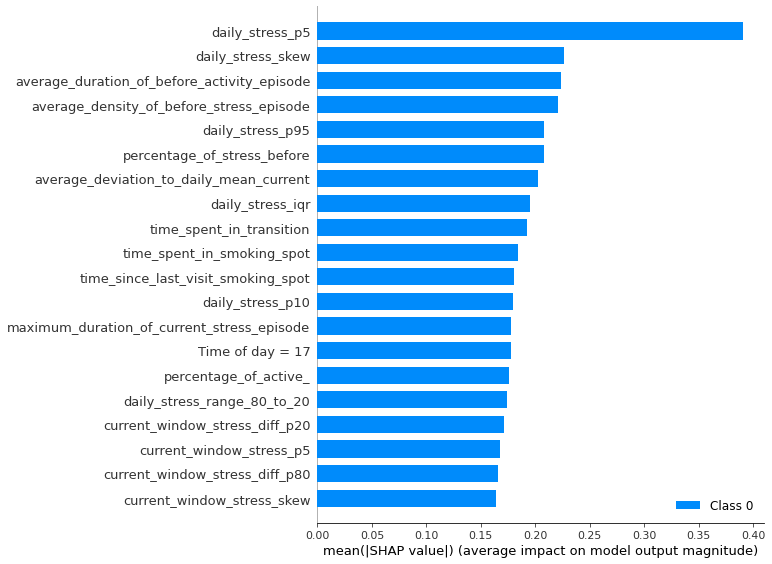

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3209242618741977 AUC 0.5969246806441633 step 0 stagnant 0
Validation Result now 0.3983286908077994 AUC 0.6708209937479435 step 20 stagnant 0
Validation Result now 0.3189269746646796 AUC 0.6239364014085544 step 40 stagnant 0
Validation Result now 0.38896952104499277 AUC 0.6867123538280955 step 60 stagnant 20
Validation Result now 0.3119266055045872 AUC 0.5593951515865883 step 80 stagnant 40
Validation Result now 0.3283132530120482 AUC 0.566971718406978 step 100 stagnant 60
Validation Result now 0.3099787685774947 AUC 0.709648941865205 step 120 stagnant 80
Validation Result now 0.281767955801105 AUC 0.6160955464533208 step 140 stagnant 100
Validation Result now 0.29954614220877457 AUC 0.5766742545908169 step 160 stagnant 120
Validation Result now 0.31610044313146235 AUC 0.6339360698973051 step 180 stagnant 140
Validation Result now 0.3496296296296296 AUC 0.6600435016428223 step 200 stagnant 160
Validation Result now 0.2861150070126227 AUC 0.6075195346073188 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24 AUC 0.6320436931826553 step 0 stagnant 0
Validation Result now 0.33894736842105266 AUC 0.7050286573057712 step 20 stagnant 0
Validation Result now 0.3727272727272727 AUC 0.6824932592712645 step 40 stagnant 0
Validation Result now 0.3398328690807799 AUC 0.6247360188200164 step 60 stagnant 0
Validation Result now 0.3552833078101072 AUC 0.6083664230672894 step 80 stagnant 20
Validation Result now 0.3401759530791789 AUC 0.6322640867724556 step 100 stagnant 40
Validation Result now 0.34685314685314683 AUC 0.6585695044029606 step 120 stagnant 60
Validation Result now 0.4 AUC 0.6316501770515636 step 140 stagnant 80
Validation Result now 0.4 AUC 0.6216759858162298 step 160 stagnant 0
Validation Result now 0.4485981308411215 AUC 0.6482800705259488 step 180 stagnant 0
Validation Result now 0.3711615487316422 AUC 0.60727949590645 step 200 stagnant 0
Validation Result now 0.34528552456839307 AUC 0.5631955597137708 step 220 stagnant 20
Validation Result now 0.377457404980

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2813816343723673 AUC 0.598225862297594 step 0 stagnant 0
Validation Result now 0.27563025210084036 AUC 0.6032178691930279 step 20 stagnant 0
Validation Result now 0.2792022792022792 AUC 0.643943412257567 step 40 stagnant 20
Validation Result now 0.31424766977363516 AUC 0.6429642262527442 step 60 stagnant 40
Validation Result now 0.3677248677248677 AUC 0.6325013628795804 step 80 stagnant 0
Validation Result now 0.3668005354752343 AUC 0.5638846733754721 step 100 stagnant 0
Validation Result now 0.3377386196769457 AUC 0.5516577404193249 step 120 stagnant 20
Validation Result now 0.35007610350076107 AUC 0.523096511519402 step 140 stagnant 40
Validation Result now 0.33587786259541985 AUC 0.5177960149892198 step 160 stagnant 60
Validation Result now 0.35400907715582447 AUC 0.6852491000083492 step 180 stagnant 80
Validation Result now 0.38461538461538464 AUC 0.7143385982230998 step 200 stagnant 100
Validation Result now 0.28245363766048504 AUC 0.5792176825644728 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21885913853317812 AUC 0.5722234091143492 step 0 stagnant 0
Validation Result now 0.31309041835357626 AUC 0.6081346721476526 step 20 stagnant 0
Validation Result now 0.3713850837138508 AUC 0.638988546900247 step 40 stagnant 0
Validation Result now 0.33962264150943394 AUC 0.6272680894638358 step 60 stagnant 0
Validation Result now 0.3443708609271523 AUC 0.6641732723352635 step 80 stagnant 20
Validation Result now 0.33692722371967654 AUC 0.6541189658813533 step 100 stagnant 40
Validation Result now 0.3564625850340136 AUC 0.6586183102257714 step 120 stagnant 60
Validation Result now 0.3739130434782609 AUC 0.688413190709827 step 140 stagnant 80
Validation Result now 0.3670520231213873 AUC 0.6934561521120951 step 160 stagnant 0
Validation Result now 0.3897849462365592 AUC 0.7315523198420533 step 180 stagnant 20
Validation Result now 0.3418803418803419 AUC 0.6521019654933624 step 200 stagnant 0
Validation Result now 0.32843791722296395 AUC 0.6783883519225197 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2426614481409002 AUC 0.606903783157264 step 0 stagnant 0
Validation Result now 0.3045822102425876 AUC 0.6741557513518293 step 20 stagnant 0
Validation Result now 0.30294906166219837 AUC 0.5828919322440119 step 40 stagnant 0
Validation Result now 0.2979310344827586 AUC 0.6529623599671925 step 60 stagnant 20
Validation Result now 0.2727272727272727 AUC 0.6599305422541784 step 80 stagnant 40
Validation Result now 0.28660436137071654 AUC 0.5737990084130189 step 100 stagnant 60
Validation Result now 0.314878892733564 AUC 0.6364880926070535 step 120 stagnant 80
Validation Result now 0.2893617021276596 AUC 0.6794258593508273 step 140 stagnant 0
Validation Result now 0.2834890965732087 AUC 0.6219540869197939 step 160 stagnant 20
Validation Result now 0.253922967189729 AUC 0.5825125360365007 step 180 stagnant 40
Validation Result now 0.27921092564491656 AUC 0.6401414693560823 step 200 stagnant 60
Validation Result now 0.2848920863309352 AUC 0.5811161983763315 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2159214830970556 AUC 0.6254051804157889 step 0 stagnant 0
Validation Result now 0.2944606413994169 AUC 0.6359343460388089 step 20 stagnant 0
Validation Result now 0.35820895522388063 AUC 0.6251909259231975 step 40 stagnant 0
Validation Result now 0.3159144893111639 AUC 0.6104230206322779 step 60 stagnant 0
Validation Result now 0.2892223738062756 AUC 0.5582468334536597 step 80 stagnant 20
Validation Result now 0.3622291021671826 AUC 0.587036129814894 step 100 stagnant 40
Validation Result now 0.37168141592920356 AUC 0.5916840403117679 step 120 stagnant 0
Validation Result now 0.33914421553090335 AUC 0.5647383148423726 step 140 stagnant 0
Validation Result now 0.31278195488721805 AUC 0.5718519937332096 step 160 stagnant 20
Validation Result now 0.31168831168831174 AUC 0.5423711280713903 step 180 stagnant 40
Validation Result now 0.3378582202111614 AUC 0.5941967727993792 step 200 stagnant 60
Validation Result now 0.3032159264931087 AUC 0.5832578224376637 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.23784417106033978 AUC 0.6185241733091698 step 0 stagnant 0
Validation Result now 0.31834750911300125 AUC 0.653299089449102 step 20 stagnant 0
Validation Result now 0.2641509433962264 AUC 0.6193023038804005 step 40 stagnant 0
Validation Result now 0.31716906946264745 AUC 0.7099107743611656 step 60 stagnant 20
Validation Result now 0.35111111111111104 AUC 0.6731563063262169 step 80 stagnant 40
Validation Result now 0.3412429378531074 AUC 0.7111861718063188 step 100 stagnant 0
Validation Result now 0.36261261261261263 AUC 0.6802537166094502 step 120 stagnant 20
Validation Result now 0.3298969072164948 AUC 0.6367750954015706 step 140 stagnant 0
Validation Result now 0.3167305236270753 AUC 0.6295456945283454 step 160 stagnant 20
Validation Result now 0.34696755994358247 AUC 0.6286776261830039 step 180 stagnant 40
Validation Result now 0.3610719322990127 AUC 0.6314294765069028 step 200 stagnant 60
Validation Result now 0.3406113537117904 AUC 0.63793078045115 step 220 

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


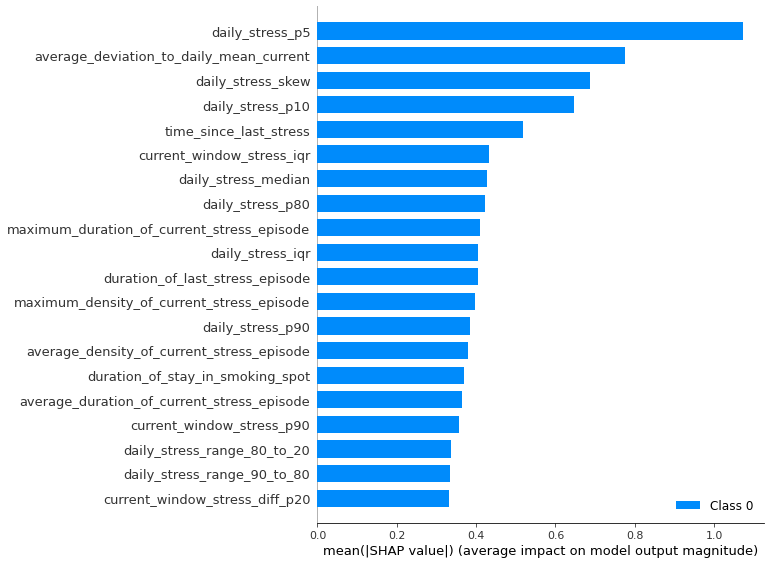

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3967479674796748 AUC 0.7001484647396243 step 0 stagnant 0
Validation Result now 0.39517345399698345 AUC 0.6748256664042289 step 20 stagnant 0
Validation Result now 0.4330275229357798 AUC 0.7220245191766955 step 40 stagnant 20
Validation Result now 0.40510948905109484 AUC 0.6697604318974242 step 60 stagnant 0
Validation Result now 0.37137989778534924 AUC 0.660736700033742 step 80 stagnant 20
Validation Result now 0.3862332695984703 AUC 0.6985035429085593 step 100 stagnant 40
Validation Result now 0.41481481481481486 AUC 0.6989511865931841 step 120 stagnant 60
Validation Result now 0.3805970149253731 AUC 0.6915442582386683 step 140 stagnant 80
Validation Result now 0.41666666666666663 AUC 0.6865521313687999 step 160 stagnant 100
Validation Result now 0.4483870967741935 AUC 0.7175750759194691 step 180 stagnant 120
Validation Result now 0.45065176908752325 AUC 0.6816859745810371 step 200 stagnant 0
Validation Result now 0.40720720720720716 AUC 0.6608598582836577 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.37818181818181823 AUC 0.6946597683050276 step 0 stagnant 0
Validation Result now 0.38420490928495193 AUC 0.6882054886964345 step 20 stagnant 0
Validation Result now 0.41474654377880177 AUC 0.698062085254752 step 40 stagnant 0
Validation Result now 0.43722304283604135 AUC 0.7024378585086042 step 60 stagnant 0
Validation Result now 0.461118690313779 AUC 0.7075885727139805 step 80 stagnant 0
Validation Result now 0.4452173913043478 AUC 0.6875441457653808 step 100 stagnant 0
Validation Result now 0.44636678200692037 AUC 0.6791586998087953 step 120 stagnant 20
Validation Result now 0.41450777202072536 AUC 0.6673186368237544 step 140 stagnant 40
Validation Result now 0.4097222222222222 AUC 0.6711708469238555 step 160 stagnant 60
Validation Result now 0.4232488822652757 AUC 0.7009239680575863 step 180 stagnant 80
Validation Result now 0.4382470119521913 AUC 0.7272562141491395 step 200 stagnant 100
Validation Result now 0.4316109422492402 AUC 0.706317062197728 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.29249011857707513 AUC 0.6390164210999887 step 0 stagnant 0
Validation Result now 0.3306581059390048 AUC 0.6318636823754359 step 20 stagnant 0
Validation Result now 0.3865546218487395 AUC 0.6414666516702284 step 40 stagnant 0
Validation Result now 0.36421725239616615 AUC 0.6397519964008549 step 60 stagnant 0
Validation Result now 0.3934426229508197 AUC 0.6738015971206839 step 80 stagnant 20
Validation Result now 0.39746835443037976 AUC 0.6825767630187831 step 100 stagnant 0
Validation Result now 0.3787878787878788 AUC 0.665857608817906 step 120 stagnant 0
Validation Result now 0.3773584905660377 AUC 0.6581278821279944 step 140 stagnant 20
Validation Result now 0.37099023709902373 AUC 0.6811888426498706 step 160 stagnant 40
Validation Result now 0.3605313092979127 AUC 0.6617933865706895 step 180 stagnant 60
Validation Result now 0.4136858475894245 AUC 0.673757732538522 step 200 stagnant 80
Validation Result now 0.3910806174957118 AUC 0.6630671465526937 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.4371184371184371 AUC 0.787115060173209 step 0 stagnant 0
Validation Result now 0.46408839779005523 AUC 0.736087616691036 step 20 stagnant 0
Validation Result now 0.45907473309608543 AUC 0.7191176470588235 step 40 stagnant 0
Validation Result now 0.5170278637770898 AUC 0.7630086604431447 step 60 stagnant 20
Validation Result now 0.48932676518883417 AUC 0.7230221572376561 step 80 stagnant 0
Validation Result now 0.4736842105263158 AUC 0.7447120683837589 step 100 stagnant 20
Validation Result now 0.4840336134453781 AUC 0.7128073332583512 step 120 stagnant 40
Validation Result now 0.48241206030150746 AUC 0.715772691485772 step 140 stagnant 60
Validation Result now 0.5191082802547771 AUC 0.7950882915307615 step 160 stagnant 80
Validation Result now 0.4967532467532468 AUC 0.7788617703295467 step 180 stagnant 0
Validation Result now 0.46511627906976744 AUC 0.6815791249578225 step 200 stagnant 20
Validation Result now 0.4903677758318739 AUC 0.7267084692385558 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3618739903069467 AUC 0.6468541221459904 step 0 stagnant 0
Validation Result now 0.37876106194690273 AUC 0.6105185018558092 step 20 stagnant 0
Validation Result now 0.3746312684365782 AUC 0.6500680463389945 step 40 stagnant 0
Validation Result now 0.42187499999999994 AUC 0.6259262175233382 step 60 stagnant 20
Validation Result now 0.4476386036960986 AUC 0.6671971656731527 step 80 stagnant 0
Validation Result now 0.42084942084942095 AUC 0.6600691710718704 step 100 stagnant 0
Validation Result now 0.4863813229571984 AUC 0.6780266561691599 step 120 stagnant 20
Validation Result now 0.3920792079207921 AUC 0.6858210549994377 step 140 stagnant 0
Validation Result now 0.4549180327868853 AUC 0.6211455404341468 step 160 stagnant 20
Validation Result now 0.444022770398482 AUC 0.6028230795186144 step 180 stagnant 40
Validation Result now 0.45229681978798586 AUC 0.6545962208975369 step 200 stagnant 60
Validation Result now 0.48330058939096265 AUC 0.6519249803171747 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.40727272727272723 AUC 0.7652553143628387 step 0 stagnant 0
Validation Result now 0.3956639566395664 AUC 0.7043133505792374 step 20 stagnant 0
Validation Result now 0.3487940630797774 AUC 0.6305724890338544 step 40 stagnant 20
Validation Result now 0.31160572337042924 AUC 0.6507597570576987 step 60 stagnant 40
Validation Result now 0.37058823529411766 AUC 0.699359464627151 step 80 stagnant 60
Validation Result now 0.35271317829457366 AUC 0.6708469238555843 step 100 stagnant 80
Validation Result now 0.35968379446640314 AUC 0.678218985490946 step 120 stagnant 100
Validation Result now 0.37804878048780494 AUC 0.679011922168485 step 140 stagnant 120
Validation Result now 0.37078651685393255 AUC 0.6694151389045102 step 160 stagnant 140
Validation Result now 0.3729508196721312 AUC 0.667305140029243 step 180 stagnant 160
Validation Result now 0.35928143712574856 AUC 0.6674058036216398 step 200 stagnant 180
Validation Result now 0.3889980353634578 AUC 0.6606439095714768 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3795966785290629 AUC 0.6615785625913846 step 0 stagnant 0
Validation Result now 0.3269230769230769 AUC 0.6467011584748622 step 20 stagnant 0
Validation Result now 0.3674074074074074 AUC 0.694090091103363 step 40 stagnant 20
Validation Result now 0.3172628304821151 AUC 0.6218625576425599 step 60 stagnant 40
Validation Result now 0.3411279229711141 AUC 0.6520678213924193 step 80 stagnant 60
Validation Result now 0.38461538461538464 AUC 0.654845911595996 step 100 stagnant 80
Validation Result now 0.3657894736842105 AUC 0.6616758519851536 step 120 stagnant 0
Validation Result now 0.36827195467422097 AUC 0.6818788662692611 step 140 stagnant 20
Validation Result now 0.36206896551724144 AUC 0.6823743111011135 step 160 stagnant 40
Validation Result now 0.35294117647058826 AUC 0.6479917894500056 step 180 stagnant 60
Validation Result now 0.3737957610789981 AUC 0.6424693510291305 step 200 stagnant 80
Validation Result now 0.37328767123287676 AUC 0.6829659205938591 step 22

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


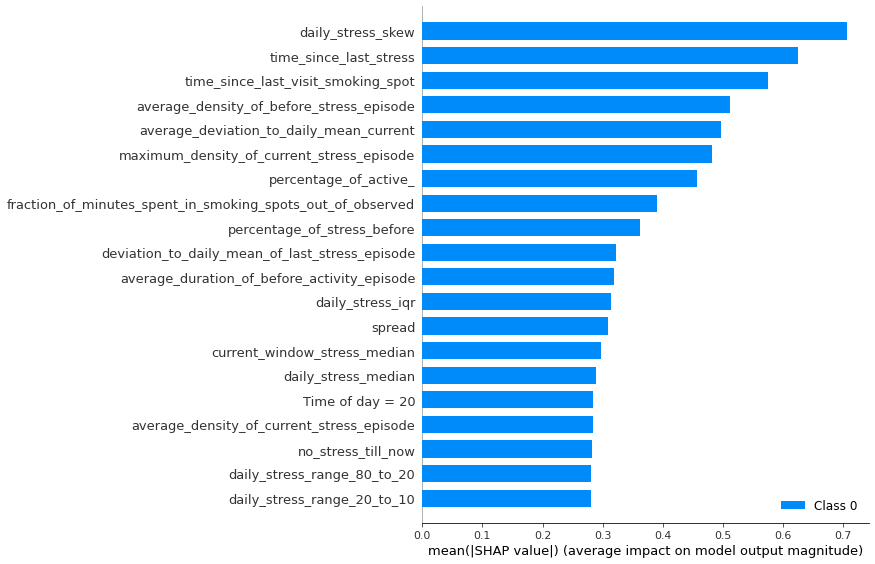

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22861842105263155 AUC 0.6734614420790779 step 0 stagnant 0
Validation Result now 0.2325915290739411 AUC 0.6030624469014919 step 20 stagnant 0
Validation Result now 0.24020887728459528 AUC 0.5576868303475927 step 40 stagnant 0
Validation Result now 0.2812846068660022 AUC 0.5716767210028666 step 60 stagnant 0
Validation Result now 0.24379232505643342 AUC 0.5614738617819095 step 80 stagnant 0
Validation Result now 0.2530521642619312 AUC 0.6134676152581428 step 100 stagnant 20
Validation Result now 0.2914669223394055 AUC 0.6301119729113568 step 120 stagnant 40
Validation Result now 0.260475651189128 AUC 0.5601848286484405 step 140 stagnant 0
Validation Result now 0.2951127819548872 AUC 0.6318902763261639 step 160 stagnant 20
Validation Result now 0.26653102746693796 AUC 0.6246639895850523 step 180 stagnant 0
Validation Result now 0.2921129503407984 AUC 0.65278709866696 step 200 stagnant 20
Validation Result now 0.2695871946082561 AUC 0.6191331878663415 step 220 stag

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3100775193798449 AUC 0.6232496592527398 step 0 stagnant 0
Validation Result now 0.34771886559802717 AUC 0.6457991822065753 step 20 stagnant 0
Validation Result now 0.36666666666666664 AUC 0.6497714090128415 step 40 stagnant 0
Validation Result now 0.35514018691588783 AUC 0.6835817885105524 step 60 stagnant 0
Validation Result now 0.32469304229195084 AUC 0.5784336016527006 step 80 stagnant 20
Validation Result now 0.33558863328822736 AUC 0.6467217974341578 step 100 stagnant 40
Validation Result now 0.34349030470914127 AUC 0.6382015879127932 step 120 stagnant 60
Validation Result now 0.35890014471780035 AUC 0.6236270788638906 step 140 stagnant 80
Validation Result now 0.3522388059701493 AUC 0.617969451931716 step 160 stagnant 100
Validation Result now 0.3625 AUC 0.6449309642994665 step 180 stagnant 120
Validation Result now 0.35488721804511275 AUC 0.6308992060436034 step 200 stagnant 140
Validation Result now 0.34782608695652173 AUC 0.6277337709567206 step 220 sta

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.29401408450704225 AUC 0.7421246126482939 step 0 stagnant 0
Validation Result now 0.23900414937759334 AUC 0.7012337190042234 step 20 stagnant 0
Validation Result now 0.3210526315789474 AUC 0.6328388678022872 step 40 stagnant 20
Validation Result now 0.34119278779472956 AUC 0.656127949832224 step 60 stagnant 0
Validation Result now 0.3498694516971279 AUC 0.6794350624346773 step 80 stagnant 0
Validation Result now 0.30494505494505497 AUC 0.6469470267891524 step 100 stagnant 0
Validation Result now 0.3076923076923077 AUC 0.6428024399337453 step 120 stagnant 20
Validation Result now 0.3255208333333333 AUC 0.6430139171571594 step 140 stagnant 40
Validation Result now 0.2859830667920978 AUC 0.6438955815929247 step 160 stagnant 60
Validation Result now 0.332955832389581 AUC 0.6350022309013452 step 180 stagnant 80
Validation Result now 0.3081896551724138 AUC 0.6296984921551729 step 200 stagnant 100
Validation Result now 0.36434108527131787 AUC 0.6134168851727574 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.28764348413234303 AUC 0.7113516206123061 step 0 stagnant 0
Validation Result now 0.258252427184466 AUC 0.6333455574502936 step 20 stagnant 0
Validation Result now 0.3058305830583058 AUC 0.6483182671091796 step 40 stagnant 20
Validation Result now 0.2815674891146589 AUC 0.6140977684874489 step 60 stagnant 0
Validation Result now 0.28160919540229884 AUC 0.6549669643239147 step 80 stagnant 20
Validation Result now 0.33251833740831294 AUC 0.686105763059941 step 100 stagnant 40
Validation Result now 0.365058670143416 AUC 0.6834082060497155 step 120 stagnant 0
Validation Result now 0.36650868878357035 AUC 0.6603101258472841 step 140 stagnant 0
Validation Result now 0.32848837209302323 AUC 0.6654002481495742 step 160 stagnant 0
Validation Result now 0.3764705882352941 AUC 0.6753039221079267 step 180 stagnant 20
Validation Result now 0.3624595469255663 AUC 0.6487155509103911 step 200 stagnant 0
Validation Result now 0.37090909090909097 AUC 0.6503031581006167 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.25716625716625713 AUC 0.6655435759209345 step 0 stagnant 0
Validation Result now 0.2424242424242424 AUC 0.5430093331132992 step 20 stagnant 0
Validation Result now 0.29123328380386326 AUC 0.6190017786090178 step 40 stagnant 20
Validation Result now 0.2889842632331903 AUC 0.6370525209185202 step 60 stagnant 0
Validation Result now 0.3040238450074516 AUC 0.6728801853176131 step 80 stagnant 20
Validation Result now 0.27245508982035926 AUC 0.6130137949159897 step 100 stagnant 0
Validation Result now 0.2649350649350649 AUC 0.5717020860455593 step 120 stagnant 20
Validation Result now 0.29949238578680204 AUC 0.5956555488322912 step 140 stagnant 40
Validation Result now 0.3037974683544304 AUC 0.5962481129019442 step 160 stagnant 60
Validation Result now 0.3110419906687402 AUC 0.6207641906717764 step 180 stagnant 80
Validation Result now 0.29289940828402367 AUC 0.5880603993619011 step 200 stagnant 0
Validation Result now 0.29346092503987237 AUC 0.6019579979341242 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.37623762376237624 AUC 0.7115710435117443 step 0 stagnant 0
Validation Result now 0.37016574585635365 AUC 0.7204225266027345 step 20 stagnant 0
Validation Result now 0.38271604938271603 AUC 0.6893035920567688 step 40 stagnant 20
Validation Result now 0.3699248120300752 AUC 0.7084172213359737 step 60 stagnant 0
Validation Result now 0.35588235294117654 AUC 0.7226451766690504 step 80 stagnant 20
Validation Result now 0.38368580060422963 AUC 0.723920457670939 step 100 stagnant 40
Validation Result now 0.42296918767507 AUC 0.7288929228474859 step 120 stagnant 0
Validation Result now 0.4011887072808321 AUC 0.6878748983870278 step 140 stagnant 0
Validation Result now 0.38006230529595014 AUC 0.6706391990758567 step 160 stagnant 20
Validation Result now 0.38271604938271603 AUC 0.6791551301562853 step 180 stagnant 40
Validation Result now 0.3780487804878049 AUC 0.66677973974855 step 200 stagnant 60
Validation Result now 0.3746223564954682 AUC 0.6431450208115592 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3007246376811594 AUC 0.6599162036782367 step 0 stagnant 0
Validation Result now 0.29352517985611515 AUC 0.6059436712690467 step 20 stagnant 0
Validation Result now 0.303030303030303 AUC 0.6215890129636761 step 40 stagnant 20
Validation Result now 0.2928348909657321 AUC 0.6188541723967216 step 60 stagnant 0
Validation Result now 0.27393617021276595 AUC 0.6434512349414159 step 80 stagnant 20
Validation Result now 0.2473404255319149 AUC 0.5389964611181399 step 100 stagnant 40
Validation Result now 0.24500000000000002 AUC 0.5906901125229966 step 120 stagnant 60
Validation Result now 0.28943089430894314 AUC 0.6893974121544395 step 140 stagnant 80
Validation Result now 0.28744326777609686 AUC 0.6045198672460899 step 160 stagnant 100
Validation Result now 0.26819126819126815 AUC 0.6741704408627782 step 180 stagnant 120
Validation Result now 0.3007856341189674 AUC 0.6596915855290904 step 200 stagnant 140
Validation Result now 0.29963459196102316 AUC 0.6711391654595351 s

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


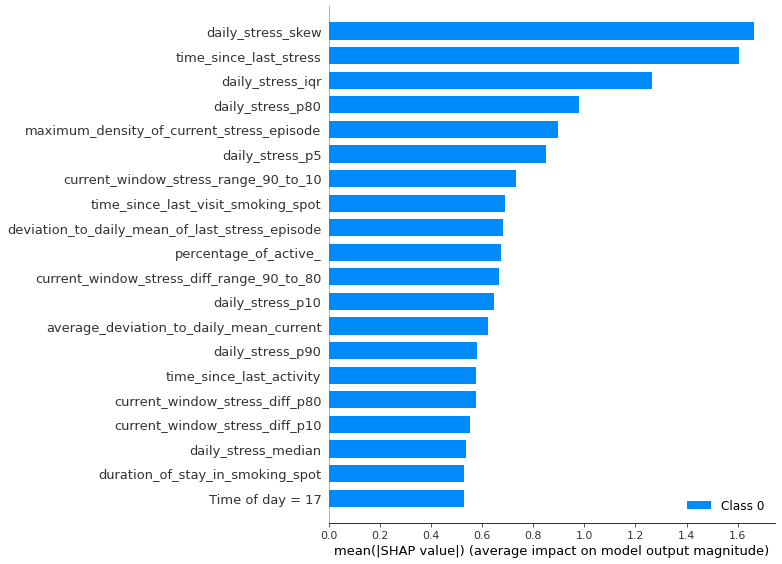

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2148900169204738 AUC 0.5812586325450686 step 0 stagnant 0
Validation Result now 0.30648330058939094 AUC 0.6481024843792043 step 20 stagnant 0
Validation Result now 0.27624309392265195 AUC 0.6385402652794803 step 40 stagnant 0
Validation Result now 0.2694610778443114 AUC 0.6898201241691331 step 60 stagnant 20
Validation Result now 0.30467899891186073 AUC 0.6816839566703539 step 80 stagnant 40
Validation Result now 0.2945417095777549 AUC 0.701578323218432 step 100 stagnant 60
Validation Result now 0.2824267782426778 AUC 0.6547532063738826 step 120 stagnant 80
Validation Result now 0.27114967462039047 AUC 0.7137738048970074 step 140 stagnant 100
Validation Result now 0.2154471544715447 AUC 0.654854056424208 step 160 stagnant 120
Validation Result now 0.28118811881188116 AUC 0.66754063400002 step 180 stagnant 140
Validation Result now 0.26406926406926406 AUC 0.6709723260286805 step 200 stagnant 160
Validation Result now 0.2657657657657657 AUC 0.6495321235313463 step

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.19930675909878684 AUC 0.5175251875990314 step 0 stagnant 0
Validation Result now 0.22421524663677128 AUC 0.5354601532681595 step 20 stagnant 0
Validation Result now 0.22966507177033493 AUC 0.5466903843662492 step 40 stagnant 0
Validation Result now 0.25775656324582336 AUC 0.6045868835142056 step 60 stagnant 0
Validation Result now 0.21115065243179124 AUC 0.5683685610930073 step 80 stagnant 0
Validation Result now 0.23570595099183195 AUC 0.5728336671749031 step 100 stagnant 20
Validation Result now 0.25 AUC 0.5952299520663298 step 120 stagnant 40
Validation Result now 0.2390804597701149 AUC 0.5749848027345112 step 140 stagnant 60
Validation Result now 0.24681933842239184 AUC 0.5905196966526154 step 160 stagnant 80
Validation Result now 0.2455661664392906 AUC 0.6081989496447328 step 180 stagnant 100
Validation Result now 0.21122112211221122 AUC 0.5676861291319122 step 200 stagnant 120
Validation Result now 0.2684365781710914 AUC 0.6022876618135071 step 220 stagnan

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21838371375694018 AUC 0.6231943157244363 step 0 stagnant 0
Validation Result now 0.24538745387453875 AUC 0.6071659342082973 step 20 stagnant 0
Validation Result now 0.2144177449168207 AUC 0.6111224052537695 step 40 stagnant 0
Validation Result now 0.2634593356242841 AUC 0.6517490308629058 step 60 stagnant 20
Validation Result now 0.2623705408515535 AUC 0.6651588986217826 step 80 stagnant 0
Validation Result now 0.22736842105263155 AUC 0.6118855571168048 step 100 stagnant 20
Validation Result now 0.22628571428571428 AUC 0.5885955733604392 step 120 stagnant 40
Validation Result now 0.23311546840958605 AUC 0.5732005939390316 step 140 stagnant 60
Validation Result now 0.22880490296220632 AUC 0.5779542985839138 step 160 stagnant 80
Validation Result now 0.2275862068965517 AUC 0.5747872881102574 step 180 stagnant 100
Validation Result now 0.20912547528517111 AUC 0.5774725701814704 step 200 stagnant 120
Validation Result now 0.22321428571428573 AUC 0.5827958982331309 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.19512195121951217 AUC 0.6090396324753107 step 0 stagnant 0
Validation Result now 0.1965881397238018 AUC 0.5743699363209662 step 20 stagnant 0
Validation Result now 0.2332065906210393 AUC 0.5935748951139547 step 40 stagnant 0
Validation Result now 0.2809917355371901 AUC 0.6022998196258982 step 60 stagnant 0
Validation Result now 0.24709609292502638 AUC 0.5464629734820174 step 80 stagnant 0
Validation Result now 0.18931583880037486 AUC 0.5764142425782535 step 100 stagnant 20
Validation Result now 0.2712700369913687 AUC 0.6359133805694241 step 120 stagnant 40
Validation Result now 0.2717520858164481 AUC 0.6408570261193658 step 140 stagnant 60
Validation Result now 0.3063063063063063 AUC 0.6502394690424228 step 160 stagnant 80
Validation Result now 0.17816091954022986 AUC 0.6646169790825834 step 180 stagnant 0
Validation Result now 0.2288888888888889 AUC 0.5732249095638136 step 200 stagnant 20
Validation Result now 0.22947131608548932 AUC 0.5589085872024078 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22197055492638731 AUC 0.5320033483811175 step 0 stagnant 0
Validation Result now 0.2014846235418876 AUC 0.5635437033493776 step 20 stagnant 0
Validation Result now 0.2312746386333771 AUC 0.5877967452938304 step 40 stagnant 20
Validation Result now 0.24858757062146894 AUC 0.5029015316850529 step 60 stagnant 0
Validation Result now 0.2222222222222222 AUC 0.5208089927950013 step 80 stagnant 0
Validation Result now 0.24935732647814907 AUC 0.5118189881112539 step 100 stagnant 20
Validation Result now 0.23798076923076925 AUC 0.5092038625967892 step 120 stagnant 0
Validation Result now 0.2684365781710914 AUC 0.5352953252214815 step 140 stagnant 20
Validation Result now 0.26046511627906976 AUC 0.5346059174663916 step 160 stagnant 0
Validation Result now 0.25103448275862067 AUC 0.5451563076125843 step 180 stagnant 20
Validation Result now 0.24203821656050956 AUC 0.5425170657817374 step 200 stagnant 40
Validation Result now 0.2480127186009539 AUC 0.5631985012008331 step 2

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22394678492239467 AUC 0.6051152500822147 step 0 stagnant 0
Validation Result now 0.22429906542056074 AUC 0.5914598343747196 step 20 stagnant 0
Validation Result now 0.22517911975435007 AUC 0.6369876528446292 step 40 stagnant 0
Validation Result now 0.24133504492939667 AUC 0.6472841240894098 step 60 stagnant 0
Validation Result now 0.2268041237113402 AUC 0.5972144658036612 step 80 stagnant 0
Validation Result now 0.2574002574002574 AUC 0.5848878391979832 step 100 stagnant 20
Validation Result now 0.24628450106157113 AUC 0.5781362671529793 step 120 stagnant 0
Validation Result now 0.2646370023419204 AUC 0.5880197713932653 step 140 stagnant 20
Validation Result now 0.25357873210633947 AUC 0.6083320876558344 step 160 stagnant 0
Validation Result now 0.27262044653349 AUC 0.6014208695825486 step 180 stagnant 20
Validation Result now 0.2874845105328377 AUC 0.5920561651070784 step 200 stagnant 0
Validation Result now 0.2486828240252898 AUC 0.5789723658903604 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1753280839895013 AUC 0.5823127746718886 step 0 stagnant 0
Validation Result now 0.2678751258811682 AUC 0.6449938712667045 step 20 stagnant 0
Validation Result now 0.25860023724792414 AUC 0.6286182945180225 step 40 stagnant 0
Validation Result now 0.23069403714565007 AUC 0.6200751392667444 step 60 stagnant 20
Validation Result now 0.25026737967914436 AUC 0.649609455190489 step 80 stagnant 40
Validation Result now 0.23746161719549644 AUC 0.6200980597327275 step 100 stagnant 60
Validation Result now 0.2624671916010498 AUC 0.6672657877166233 step 120 stagnant 80
Validation Result now 0.27576974564926376 AUC 0.645336482406051 step 140 stagnant 100
Validation Result now 0.24289405684754523 AUC 0.6532021884062303 step 160 stagnant 0
Validation Result now 0.26616915422885573 AUC 0.6706980776704834 step 180 stagnant 20
Validation Result now 0.23877327491785322 AUC 0.6446285389697749 step 200 stagnant 40
Validation Result now 0.26700898587933247 AUC 0.6285911885756426 ste

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


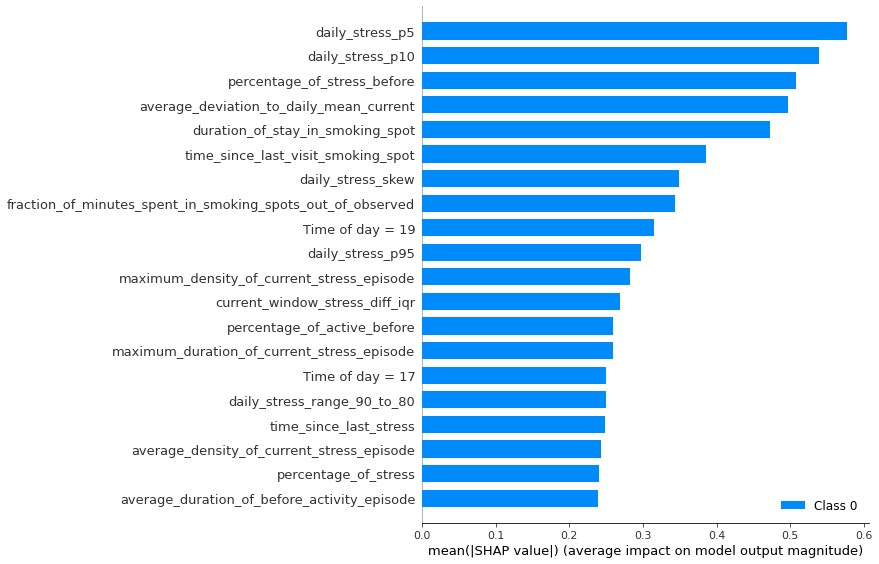

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.19254237288135595 AUC 0.49602423538333695 step 0 stagnant 0
Validation Result now 0.19912663755458518 AUC 0.5194564787698364 step 20 stagnant 0
Validation Result now 0.1880597014925373 AUC 0.4871812248388476 step 40 stagnant 0
Validation Result now 0.19446415897799857 AUC 0.5371437100144412 step 60 stagnant 20
Validation Result now 0.19960861056751467 AUC 0.5089866156787763 step 80 stagnant 40
Validation Result now 0.22239624119028975 AUC 0.5781131253479197 step 100 stagnant 0
Validation Result now 0.21422450728363324 AUC 0.5606953554227073 step 120 stagnant 0
Validation Result now 0.22330097087378642 AUC 0.5787280860985389 step 140 stagnant 20
Validation Result now 0.23940677966101695 AUC 0.5480756508620342 step 160 stagnant 0
Validation Result now 0.21280991735537189 AUC 0.570610765544449 step 180 stagnant 0
Validation Result now 0.1954674220963173 AUC 0.5485123153504208 step 200 stagnant 20
Validation Result now 0.2302158273381295 AUC 0.6037430113512597 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.19876868953386104 AUC 0.5943070245500238 step 0 stagnant 0
Validation Result now 0.20133111480865226 AUC 0.57482694774548 step 20 stagnant 0
Validation Result now 0.21490803484995158 AUC 0.5445821332623375 step 40 stagnant 0
Validation Result now 0.236493374108053 AUC 0.563299408637284 step 60 stagnant 0
Validation Result now 0.23660714285714285 AUC 0.5833216351622819 step 80 stagnant 0
Validation Result now 0.2622169249106079 AUC 0.6146545812458148 step 100 stagnant 0
Validation Result now 0.16253802694480662 AUC 0.5678768222926802 step 120 stagnant 0
Validation Result now 0.19416058394160585 AUC 0.5700627667384692 step 140 stagnant 20
Validation Result now 0.24948024948024947 AUC 0.6075043767295141 step 160 stagnant 40
Validation Result now 0.2735229759299781 AUC 0.5756831328508847 step 180 stagnant 60
Validation Result now 0.2760084925690021 AUC 0.6100880589910529 step 200 stagnant 0
Validation Result now 0.27243928194297784 AUC 0.6200137554356157 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.17073170731707318 AUC 0.5375251107292398 step 0 stagnant 0
Validation Result now 0.18585526315789472 AUC 0.5603583270808626 step 20 stagnant 0
Validation Result now 0.1930646672914714 AUC 0.5207404538890368 step 40 stagnant 0
Validation Result now 0.20662768031189083 AUC 0.5273148260199595 step 60 stagnant 0
Validation Result now 0.180620884289746 AUC 0.5300721656138312 step 80 stagnant 0
Validation Result now 0.21451104100946375 AUC 0.5285235697977426 step 100 stagnant 20
Validation Result now 0.1951530612244898 AUC 0.5412453308162096 step 120 stagnant 0
Validation Result now 0.1994750656167979 AUC 0.5356610676799702 step 140 stagnant 20
Validation Result now 0.1967493584260051 AUC 0.5426263200780954 step 160 stagnant 40
Validation Result now 0.21075268817204298 AUC 0.5637106598575243 step 180 stagnant 60
Validation Result now 0.21298174442190668 AUC 0.5628564916781632 step 200 stagnant 80
Validation Result now 0.22840690978886757 AUC 0.5768698921347952 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.16033254156769594 AUC 0.5012970851384821 step 0 stagnant 0
Validation Result now 0.16952573158425832 AUC 0.49891227178481823 step 20 stagnant 0
Validation Result now 0.1613316261203585 AUC 0.5511498495373173 step 40 stagnant 0
Validation Result now 0.21443298969072166 AUC 0.5507039071891312 step 60 stagnant 20
Validation Result now 0.19193857965451058 AUC 0.539896208985809 step 80 stagnant 0
Validation Result now 0.18507462686567164 AUC 0.5541913740106977 step 100 stagnant 20
Validation Result now 0.16823899371069181 AUC 0.5281038474881202 step 120 stagnant 40
Validation Result now 0.15531660692951016 AUC 0.531328710538842 step 140 stagnant 60
Validation Result now 0.19934994582881907 AUC 0.5458925301127058 step 160 stagnant 80
Validation Result now 0.2235528942115768 AUC 0.592776984453534 step 180 stagnant 100
Validation Result now 0.19658976930792377 AUC 0.5615985349049221 step 200 stagnant 0
Validation Result now 0.18703855619360135 AUC 0.5439939976280949 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.15690607734806633 AUC 0.4545138804850304 step 0 stagnant 0
Validation Result now 0.21653878942881502 AUC 0.546301361021694 step 20 stagnant 0
Validation Result now 0.2265895953757225 AUC 0.4926577841243717 step 40 stagnant 0
Validation Result now 0.21348314606741575 AUC 0.5212396430847674 step 60 stagnant 0
Validation Result now 0.24842105263157896 AUC 0.5522119627917483 step 80 stagnant 20
Validation Result now 0.24757804090419805 AUC 0.582235117102726 step 100 stagnant 0
Validation Result now 0.24363233665559245 AUC 0.5733422884849658 step 120 stagnant 20
Validation Result now 0.23425692695214104 AUC 0.5712329872288243 step 140 stagnant 40
Validation Result now 0.21222606689734716 AUC 0.5759735702011278 step 160 stagnant 60
Validation Result now 0.22039134912461378 AUC 0.5795586562431929 step 180 stagnant 80
Validation Result now 0.22222222222222224 AUC 0.5211539237279248 step 200 stagnant 100
Validation Result now 0.2217898832684825 AUC 0.5357018095860461 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.15 AUC 0.5013460964413357 step 0 stagnant 0
Validation Result now 0.19873532068654018 AUC 0.5528204693790288 step 20 stagnant 0
Validation Result now 0.20050761421319793 AUC 0.5747186388169518 step 40 stagnant 0
Validation Result now 0.2245322245322245 AUC 0.5887495865301611 step 60 stagnant 0
Validation Result now 0.24179620034542315 AUC 0.5765578736758881 step 80 stagnant 0
Validation Result now 0.23153252480705622 AUC 0.6048041161426694 step 100 stagnant 0
Validation Result now 0.20552147239263802 AUC 0.5919500447757581 step 120 stagnant 20
Validation Result now 0.21935483870967742 AUC 0.6275899347322732 step 140 stagnant 40
Validation Result now 0.2162645218945487 AUC 0.5452037498688999 step 160 stagnant 60
Validation Result now 0.20400381315538607 AUC 0.5578416067639631 step 180 stagnant 80
Validation Result now 0.21634615384615385 AUC 0.6396644641834273 step 200 stagnant 100
Validation Result now 0.23036649214659688 AUC 0.5644290889141678 step 220 stagnant

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.20065789473684212 AUC 0.5583119539172738 step 0 stagnant 0
Validation Result now 0.21271076523994809 AUC 0.5628734338569273 step 20 stagnant 0
Validation Result now 0.20353063343717548 AUC 0.4488229219610975 step 40 stagnant 0
Validation Result now 0.25234619395203334 AUC 0.5954754298069398 step 60 stagnant 20
Validation Result now 0.2537485582468281 AUC 0.5809650587732249 step 80 stagnant 0
Validation Result now 0.21735959153902262 AUC 0.5544100087937975 step 100 stagnant 0
Validation Result now 0.22684310018903592 AUC 0.5390192495421577 step 120 stagnant 20
Validation Result now 0.2272317403065825 AUC 0.5434133246202129 step 140 stagnant 40
Validation Result now 0.20575221238938052 AUC 0.5662830473332203 step 160 stagnant 60
Validation Result now 0.2072155411655874 AUC 0.5781006204064509 step 180 stagnant 80
Validation Result now 0.2234891676168757 AUC 0.5756500552637736 step 200 stagnant 100
Validation Result now 0.2109704641350211 AUC 0.5582149397745884 step

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


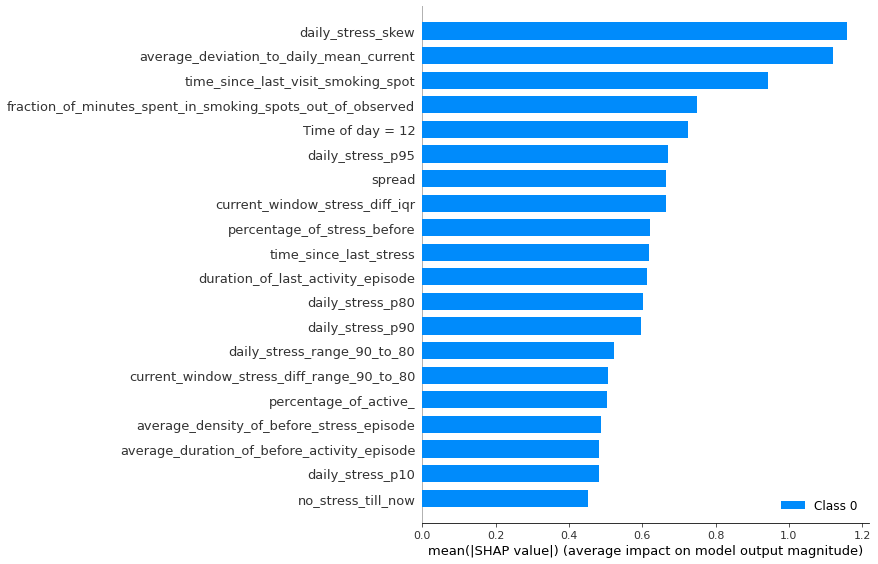

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.21303656597774245 AUC 0.5392464891651149 step 0 stagnant 0
Validation Result now 0.16061452513966482 AUC 0.48772871777768556 step 20 stagnant 0
Validation Result now 0.25511038430089944 AUC 0.5696507630009318 step 40 stagnant 20
Validation Result now 0.22153846153846155 AUC 0.5364619043461208 step 60 stagnant 0
Validation Result now 0.23104693140794222 AUC 0.5102673401820438 step 80 stagnant 20
Validation Result now 0.22446689113355783 AUC 0.5093847110673425 step 100 stagnant 40
Validation Result now 0.24600000000000002 AUC 0.5500779748161742 step 120 stagnant 60
Validation Result now 0.22512562814070353 AUC 0.5089230887044944 step 140 stagnant 80
Validation Result now 0.2401433691756272 AUC 0.5155489799219322 step 160 stagnant 100
Validation Result now 0.1929824561403509 AUC 0.492585593374395 step 180 stagnant 120
Validation Result now 0.20608439646712465 AUC 0.5577301706356648 step 200 stagnant 140
Validation Result now 0.2127659574468085 AUC 0.537464948906634

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.1780564263322884 AUC 0.5970092238589341 step 0 stagnant 0
Validation Result now 0.17025440313111545 AUC 0.5412774486382499 step 20 stagnant 0
Validation Result now 0.1936989498249708 AUC 0.5660943026496408 step 40 stagnant 20
Validation Result now 0.21639344262295082 AUC 0.5495726951445916 step 60 stagnant 0
Validation Result now 0.20280296784830998 AUC 0.5443406171855206 step 80 stagnant 0
Validation Result now 0.20972972972972975 AUC 0.5479484285515936 step 100 stagnant 20
Validation Result now 0.21375464684014872 AUC 0.5416490725326821 step 120 stagnant 40
Validation Result now 0.20266666666666666 AUC 0.5670796337939061 step 140 stagnant 60
Validation Result now 0.25088757396449707 AUC 0.5985286413416105 step 160 stagnant 80
Validation Result now 0.24565756823821341 AUC 0.5566364119131492 step 180 stagnant 0
Validation Result now 0.2345549738219895 AUC 0.5585460613234892 step 200 stagnant 20
Validation Result now 0.23076923076923073 AUC 0.5593479959863903 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.17547169811320754 AUC 0.5467292445281647 step 0 stagnant 0
Validation Result now 0.21818181818181814 AUC 0.5552946653631501 step 20 stagnant 0
Validation Result now 0.22522522522522526 AUC 0.609902801654111 step 40 stagnant 0
Validation Result now 0.25105932203389836 AUC 0.625567902860341 step 60 stagnant 0
Validation Result now 0.28791773778920304 AUC 0.5999135084301548 step 80 stagnant 0
Validation Result now 0.2997416020671835 AUC 0.5939369302184441 step 100 stagnant 0
Validation Result now 0.2871536523929471 AUC 0.5661202465421264 step 120 stagnant 0
Validation Result now 0.2686567164179105 AUC 0.572767429643742 step 140 stagnant 20
Validation Result now 0.2807017543859649 AUC 0.6114154200477224 step 160 stagnant 40
Validation Result now 0.2574257425742574 AUC 0.5878792997081401 step 180 stagnant 60
Validation Result now 0.2713178294573643 AUC 0.6005077130297742 step 200 stagnant 80
Validation Result now 0.27831715210355984 AUC 0.6141277198145495 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.20352681851579718 AUC 0.5965810601712225 step 0 stagnant 0
Validation Result now 0.2187192118226601 AUC 0.5810522985930896 step 20 stagnant 0
Validation Result now 0.23501199040767387 AUC 0.5743840025306926 step 40 stagnant 0
Validation Result now 0.1862295081967213 AUC 0.5619318287545644 step 60 stagnant 0
Validation Result now 0.21086956521739128 AUC 0.5609609904054118 step 80 stagnant 20
Validation Result now 0.21348314606741572 AUC 0.5727520422316471 step 100 stagnant 40
Validation Result now 0.21112372304199775 AUC 0.4968110483050229 step 120 stagnant 60
Validation Result now 0.23120089786756454 AUC 0.5641785698438213 step 140 stagnant 80
Validation Result now 0.22366992399565688 AUC 0.5497877610671278 step 160 stagnant 100
Validation Result now 0.22608695652173913 AUC 0.547570363414889 step 180 stagnant 120
Validation Result now 0.2275711159737418 AUC 0.5426594529524508 step 200 stagnant 140
Validation Result now 0.2267818574514039 AUC 0.5382720723480332 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.18210036213140196 AUC 0.5354046459964817 step 0 stagnant 0
Validation Result now 0.23093371347113328 AUC 0.5787946431766489 step 20 stagnant 0
Validation Result now 0.26634958382877527 AUC 0.5786235924096401 step 40 stagnant 0
Validation Result now 0.21706864564007422 AUC 0.5487644981628146 step 60 stagnant 0
Validation Result now 0.2491525423728814 AUC 0.5839658871809259 step 80 stagnant 20
Validation Result now 0.229957805907173 AUC 0.5772584068947058 step 100 stagnant 40
Validation Result now 0.23649337410805302 AUC 0.5894858528848893 step 120 stagnant 60
Validation Result now 0.2908011869436202 AUC 0.6066125793167417 step 140 stagnant 80
Validation Result now 0.2704761904761904 AUC 0.5912774128535705 step 160 stagnant 0
Validation Result now 0.29586935638808837 AUC 0.59494945771897 step 180 stagnant 20
Validation Result now 0.23976608187134504 AUC 0.5886440183045791 step 200 stagnant 0
Validation Result now 0.23714585519412384 AUC 0.5558822497971009 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.18684759916492694 AUC 0.5525193845607717 step 0 stagnant 0
Validation Result now 0.22592592592592595 AUC 0.6128589740103031 step 20 stagnant 0
Validation Result now 0.22070015220700154 AUC 0.5909650126033641 step 40 stagnant 0
Validation Result now 0.18823529411764708 AUC 0.5502477731194079 step 60 stagnant 20
Validation Result now 0.20000000000000004 AUC 0.5748957234445474 step 80 stagnant 40
Validation Result now 0.20097560975609755 AUC 0.5608917470509847 step 100 stagnant 60
Validation Result now 0.208955223880597 AUC 0.5978460485841434 step 120 stagnant 80
Validation Result now 0.21019771071800208 AUC 0.5641610353509691 step 140 stagnant 100
Validation Result now 0.22245989304812835 AUC 0.5723870385028834 step 160 stagnant 120
Validation Result now 0.22245322245322247 AUC 0.5723222682333677 step 180 stagnant 140
Validation Result now 0.2284434490481523 AUC 0.570764918990643 step 200 stagnant 160
Validation Result now 0.2354235423542354 AUC 0.5771786070598878

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.19294990723562153 AUC 0.5543869869729453 step 0 stagnant 0
Validation Result now 0.22754491017964074 AUC 0.5606163839438438 step 20 stagnant 0
Validation Result now 0.2059447983014862 AUC 0.5531640455581909 step 40 stagnant 0
Validation Result now 0.23574879227053142 AUC 0.5289931050079943 step 60 stagnant 20
Validation Result now 0.26008968609865474 AUC 0.5702134770827757 step 80 stagnant 0
Validation Result now 0.24975024975024976 AUC 0.5678606344194222 step 100 stagnant 0
Validation Result now 0.23227383863080686 AUC 0.5619812116119853 step 120 stagnant 20
Validation Result now 0.2967032967032967 AUC 0.5861296078142288 step 140 stagnant 40
Validation Result now 0.2570281124497992 AUC 0.5853786663193167 step 160 stagnant 0
Validation Result now 0.2948593598448108 AUC 0.6100434354437229 step 180 stagnant 20
Validation Result now 0.21511111111111111 AUC 0.5696552360858431 step 200 stagnant 40
Validation Result now 0.2777276825969342 AUC 0.6071928278914378 step 2

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


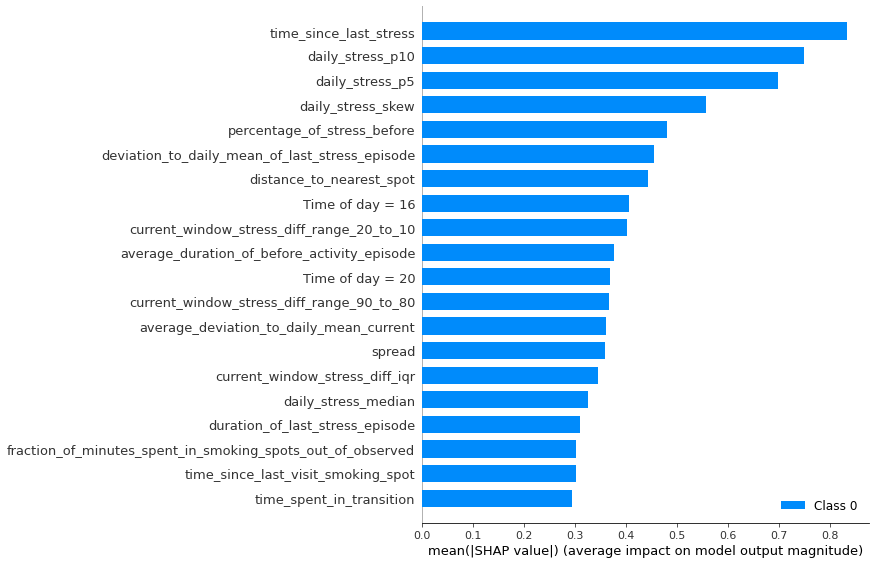

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.25426356589147286 AUC 0.5265908674124335 step 0 stagnant 0
Validation Result now 0.26273885350318477 AUC 0.5748083969703366 step 20 stagnant 0
Validation Result now 0.2443991853360489 AUC 0.5610441197332955 step 40 stagnant 0
Validation Result now 0.2806026365348399 AUC 0.5887399700355352 step 60 stagnant 20
Validation Result now 0.26890756302521013 AUC 0.5772041701123495 step 80 stagnant 0
Validation Result now 0.2630718954248366 AUC 0.5745713801300305 step 100 stagnant 20
Validation Result now 0.24448529411764705 AUC 0.5474758571532374 step 120 stagnant 40
Validation Result now 0.2640207075064711 AUC 0.5976223923822441 step 140 stagnant 60
Validation Result now 0.28318584070796465 AUC 0.603705766948434 step 160 stagnant 80
Validation Result now 0.23293172690763053 AUC 0.5763320519430191 step 180 stagnant 0
Validation Result now 0.23421588594704681 AUC 0.5616041368953908 step 200 stagnant 20
Validation Result now 0.24702058504875404 AUC 0.5842859564927043 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24178047546788062 AUC 0.5972701542166508 step 0 stagnant 0
Validation Result now 0.30726256983240224 AUC 0.6184881785688334 step 20 stagnant 0
Validation Result now 0.24882629107981225 AUC 0.5856949091550783 step 40 stagnant 0
Validation Result now 0.2310756972111554 AUC 0.5427209879277116 step 60 stagnant 20
Validation Result now 0.22779922779922782 AUC 0.5421831154047105 step 80 stagnant 40
Validation Result now 0.26170212765957446 AUC 0.5153022916241362 step 100 stagnant 60
Validation Result now 0.2801175318315377 AUC 0.5546643876142265 step 120 stagnant 80
Validation Result now 0.2443064182194617 AUC 0.5392178098259915 step 140 stagnant 100
Validation Result now 0.23952095808383234 AUC 0.5559141756831102 step 160 stagnant 120
Validation Result now 0.2386740331491713 AUC 0.5377981308540565 step 180 stagnant 140
Validation Result now 0.22494887525562376 AUC 0.5090985055828712 step 200 stagnant 160
Validation Result now 0.26249999999999996 AUC 0.514040047195762

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24229691876750703 AUC 0.5473436813386434 step 0 stagnant 0
Validation Result now 0.26686004350978965 AUC 0.5806274199073385 step 20 stagnant 0
Validation Result now 0.2683114880493447 AUC 0.5956253957489213 step 40 stagnant 0
Validation Result now 0.2923636363636363 AUC 0.6074364466158493 step 60 stagnant 0
Validation Result now 0.2890855457227139 AUC 0.6259355244992371 step 80 stagnant 0
Validation Result now 0.28331584470094445 AUC 0.6188805538927853 step 100 stagnant 20
Validation Result now 0.2628250175685172 AUC 0.6404783242044365 step 120 stagnant 40
Validation Result now 0.24173318129988597 AUC 0.5865755045690618 step 140 stagnant 60
Validation Result now 0.2495238095238095 AUC 0.6018644748087429 step 160 stagnant 80
Validation Result now 0.24463519313304724 AUC 0.5854319415658336 step 180 stagnant 100
Validation Result now 0.2595419847328244 AUC 0.5960006435785736 step 200 stagnant 120
Validation Result now 0.2606837606837607 AUC 0.5969879830731915 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.20378719567177636 AUC 0.5029758588832873 step 0 stagnant 0
Validation Result now 0.19836639439906653 AUC 0.5233210730461682 step 20 stagnant 0
Validation Result now 0.18947368421052632 AUC 0.49423945275060643 step 40 stagnant 20
Validation Result now 0.20047732696897377 AUC 0.5078590978135629 step 60 stagnant 40
Validation Result now 0.1911987860394537 AUC 0.5593275641935026 step 80 stagnant 60
Validation Result now 0.24102564102564103 AUC 0.5564600064357857 step 100 stagnant 80
Validation Result now 0.22545454545454546 AUC 0.530749561432343 step 120 stagnant 0
Validation Result now 0.24736842105263157 AUC 0.49147881207851657 step 140 stagnant 20
Validation Result now 0.25132275132275134 AUC 0.5638985291115501 step 160 stagnant 0
Validation Result now 0.2506393861892583 AUC 0.5286065485849922 step 180 stagnant 0
Validation Result now 0.22835633626097868 AUC 0.47946430733990986 step 200 stagnant 20
Validation Result now 0.23455233291298863 AUC 0.5260080135912722 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.18968180413963548 AUC 0.5333404842063743 step 0 stagnant 0
Validation Result now 0.20837487537387836 AUC 0.5530256843212495 step 20 stagnant 0
Validation Result now 0.19219219219219222 AUC 0.5212848042794516 step 40 stagnant 0
Validation Result now 0.2165525824517735 AUC 0.5554508683120596 step 60 stagnant 20
Validation Result now 0.2031905961376994 AUC 0.5450267984734039 step 80 stagnant 0
Validation Result now 0.2155688622754491 AUC 0.5580488842908007 step 100 stagnant 20
Validation Result now 0.19931856899488926 AUC 0.5571371479780906 step 120 stagnant 40
Validation Result now 0.19840566873339238 AUC 0.5449833742201801 step 140 stagnant 60
Validation Result now 0.19060052219321147 AUC 0.5445517267628344 step 160 stagnant 80
Validation Result now 0.23642732049036774 AUC 0.5623843894134785 step 180 stagnant 100
Validation Result now 0.19086294416243654 AUC 0.5441747488832527 step 200 stagnant 0
Validation Result now 0.20023837902264602 AUC 0.5352454421834614 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2534113060428849 AUC 0.5807800103110976 step 0 stagnant 0
Validation Result now 0.3068783068783068 AUC 0.5948020649875956 step 20 stagnant 0
Validation Result now 0.27453874538745393 AUC 0.6071868004110599 step 40 stagnant 0
Validation Result now 0.281764318630678 AUC 0.6005231670986024 step 60 stagnant 20
Validation Result now 0.31543624161073824 AUC 0.6175461663823618 step 80 stagnant 40
Validation Result now 0.28289473684210525 AUC 0.5976486891411686 step 100 stagnant 0
Validation Result now 0.25000000000000006 AUC 0.5768609282063881 step 120 stagnant 20
Validation Result now 0.293353705118411 AUC 0.6202019660287394 step 140 stagnant 40
Validation Result now 0.28888888888888886 AUC 0.5909447456653599 step 160 stagnant 60
Validation Result now 0.2882288228822883 AUC 0.5994401558428976 step 180 stagnant 80
Validation Result now 0.28365878725590954 AUC 0.582864028455861 step 200 stagnant 100
Validation Result now 0.2839378238341969 AUC 0.5964269278811386 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2551546391752577 AUC 0.5864959222723167 step 0 stagnant 0
Validation Result now 0.2594086021505376 AUC 0.5705616434090288 step 20 stagnant 0
Validation Result now 0.2734026745913818 AUC 0.563864620132937 step 40 stagnant 0
Validation Result now 0.2661396574440053 AUC 0.5721949835472251 step 60 stagnant 0
Validation Result now 0.2786885245901639 AUC 0.6144953963371382 step 80 stagnant 20
Validation Result now 0.21346153846153845 AUC 0.5691672231660605 step 100 stagnant 0
Validation Result now 0.269162210338681 AUC 0.6132616977325965 step 120 stagnant 20
Validation Result now 0.23762376237623764 AUC 0.5580232795518478 step 140 stagnant 40
Validation Result now 0.2377994676131322 AUC 0.5510705548962144 step 160 stagnant 60
Validation Result now 0.2495755517826825 AUC 0.6231266154341214 step 180 stagnant 80
Validation Result now 0.2309278350515464 AUC 0.5856859128954461 step 200 stagnant 100
Validation Result now 0.20060180541624878 AUC 0.5280579497524298 step 220 s

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


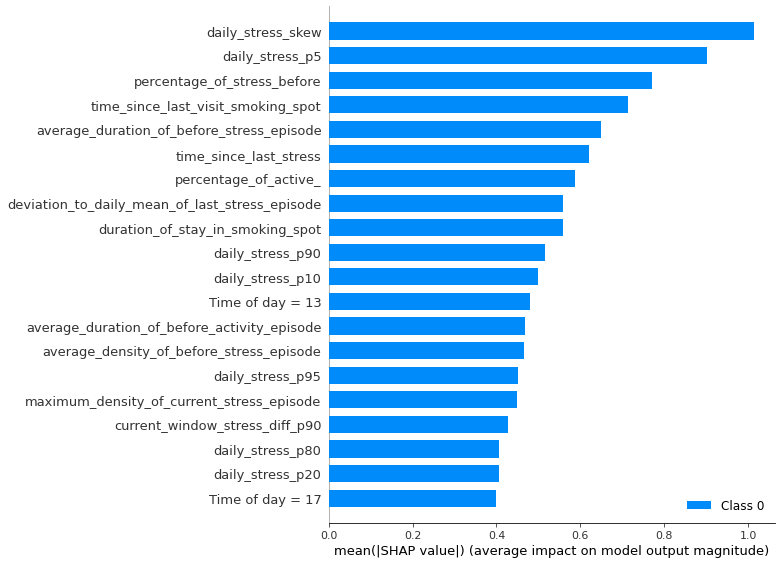

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3350877192982456 AUC 0.6324854867561752 step 0 stagnant 0
Validation Result now 0.2774798927613941 AUC 0.5677858599698653 step 20 stagnant 0
Validation Result now 0.27716994894237784 AUC 0.6045696848392852 step 40 stagnant 20
Validation Result now 0.3266423357664234 AUC 0.6314173388766873 step 60 stagnant 40
Validation Result now 0.28749028749028754 AUC 0.6283819272334051 step 80 stagnant 60
Validation Result now 0.3090745732255166 AUC 0.6261296598538937 step 100 stagnant 80
Validation Result now 0.27256944444444436 AUC 0.6315928634915517 step 120 stagnant 100
Validation Result now 0.2862190812720848 AUC 0.6190777793449618 step 140 stagnant 120
Validation Result now 0.31173380035026266 AUC 0.6413116435059251 step 160 stagnant 140
Validation Result now 0.2775290957923008 AUC 0.6173579067794143 step 180 stagnant 160
Validation Result now 0.3032928942807626 AUC 0.6509372880103703 step 200 stagnant 180
Validation Result now 0.31578947368421056 AUC 0.6111209619823535

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3062972292191436 AUC 0.5990484953913595 step 0 stagnant 0
Validation Result now 0.35430296930045296 AUC 0.6412697773031449 step 20 stagnant 0
Validation Result now 0.2897727272727273 AUC 0.5742133295720915 step 40 stagnant 0
Validation Result now 0.2617033276931754 AUC 0.5620571305755371 step 60 stagnant 20
Validation Result now 0.27683284457478 AUC 0.5749850557805584 step 80 stagnant 40
Validation Result now 0.25630252100840334 AUC 0.5438437651820954 step 100 stagnant 60
Validation Result now 0.3309914129586261 AUC 0.6175325358605296 step 120 stagnant 80
Validation Result now 0.3178438661710037 AUC 0.6149428761409659 step 140 stagnant 100
Validation Result now 0.3263888888888889 AUC 0.59542986739384 step 160 stagnant 120
Validation Result now 0.3204524033930255 AUC 0.5959705458949852 step 180 stagnant 140
Validation Result now 0.2811176968670618 AUC 0.6166620770562016 step 200 stagnant 160
Validation Result now 0.2996941896024464 AUC 0.6406500679486233 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.26993865030674846 AUC 0.5527037283308818 step 0 stagnant 0
Validation Result now 0.3395585738539898 AUC 0.6183197100261719 step 20 stagnant 0
Validation Result now 0.3396704689480355 AUC 0.6647397019215915 step 40 stagnant 0
Validation Result now 0.28551912568306015 AUC 0.615755125251589 step 60 stagnant 0
Validation Result now 0.2993667242371906 AUC 0.6163558045139379 step 80 stagnant 20
Validation Result now 0.28780487804878047 AUC 0.5661286747667695 step 100 stagnant 40
Validation Result now 0.29844097995545654 AUC 0.5829239624681806 step 120 stagnant 60
Validation Result now 0.27575522850503487 AUC 0.5469353715681468 step 140 stagnant 80
Validation Result now 0.2894308943089431 AUC 0.5656703853705607 step 160 stagnant 100
Validation Result now 0.28690575479566305 AUC 0.5662950201607035 step 180 stagnant 120
Validation Result now 0.28651059085841696 AUC 0.5386781026326453 step 200 stagnant 140
Validation Result now 0.30437804030576787 AUC 0.5928511779627055 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.33777038269550747 AUC 0.5824782105444621 step 0 stagnant 0
Validation Result now 0.27116311080523053 AUC 0.5715681467600708 step 20 stagnant 0
Validation Result now 0.3104089219330855 AUC 0.5667877876062607 step 40 stagnant 20
Validation Result now 0.2799325463743676 AUC 0.5545756177503744 step 60 stagnant 40
Validation Result now 0.3333333333333333 AUC 0.5945878417860524 step 80 stagnant 60
Validation Result now 0.29227557411273486 AUC 0.579249139727892 step 100 stagnant 80
Validation Result now 0.286215978928885 AUC 0.5524317099545293 step 120 stagnant 100
Validation Result now 0.30228758169934644 AUC 0.6037368384524282 step 140 stagnant 120
Validation Result now 0.2698675496688742 AUC 0.6078889806810982 step 160 stagnant 140
Validation Result now 0.2944317315026697 AUC 0.581355211222829 step 180 stagnant 160
Validation Result now 0.31198686371100165 AUC 0.5876064845598787 step 200 stagnant 180
Validation Result now 0.2812241521918941 AUC 0.5912217543058381 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2797055730809674 AUC 0.5544524818598444 step 0 stagnant 0
Validation Result now 0.33715798764342453 AUC 0.6314135328582526 step 20 stagnant 0
Validation Result now 0.3364140480591497 AUC 0.612335753513291 step 40 stagnant 0
Validation Result now 0.30210325047801145 AUC 0.6043610254756964 step 60 stagnant 20
Validation Result now 0.31961722488038274 AUC 0.6462845424158365 step 80 stagnant 40
Validation Result now 0.2948986722571628 AUC 0.6228343195398748 step 100 stagnant 60
Validation Result now 0.2809070958302853 AUC 0.6161330404937974 step 120 stagnant 80
Validation Result now 0.30793157076205285 AUC 0.6425112109631241 step 140 stagnant 100
Validation Result now 0.3231240428790199 AUC 0.6487535289626809 step 160 stagnant 120
Validation Result now 0.311787072243346 AUC 0.6395246059091795 step 180 stagnant 140
Validation Result now 0.3094841930116472 AUC 0.6464493206257094 step 200 stagnant 160
Validation Result now 0.31311475409836065 AUC 0.6537033678785478 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2891705069124424 AUC 0.5690637866301289 step 0 stagnant 0
Validation Result now 0.3277511961722488 AUC 0.6337394578886449 step 20 stagnant 0
Validation Result now 0.31853785900783294 AUC 0.5808832649369432 step 40 stagnant 0
Validation Result now 0.3090128755364807 AUC 0.6008838918105678 step 60 stagnant 20
Validation Result now 0.3231441048034934 AUC 0.6006781429316641 step 80 stagnant 40
Validation Result now 0.32079815809669987 AUC 0.6063204533191838 step 100 stagnant 60
Validation Result now 0.3093829247675402 AUC 0.6175869395358001 step 120 stagnant 80
Validation Result now 0.2945606694560669 AUC 0.5923722912902626 step 140 stagnant 100
Validation Result now 0.30068337129840544 AUC 0.6025280917742987 step 160 stagnant 120
Validation Result now 0.28752260397830015 AUC 0.582196789063742 step 180 stagnant 140
Validation Result now 0.2850041425020713 AUC 0.5743322116773124 step 200 stagnant 160
Validation Result now 0.30260869565217385 AUC 0.5774047879711908 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24075531077891427 AUC 0.5017792016764392 step 0 stagnant 0
Validation Result now 0.257761053621825 AUC 0.5590855257118934 step 20 stagnant 0
Validation Result now 0.2900251466890193 AUC 0.543087934697679 step 40 stagnant 0
Validation Result now 0.24158757549611734 AUC 0.509792437665254 step 60 stagnant 0
Validation Result now 0.31522707034728403 AUC 0.5776640449916155 step 80 stagnant 20
Validation Result now 0.30123927550047663 AUC 0.5625487786039076 step 100 stagnant 0
Validation Result now 0.27715355805243447 AUC 0.5687848278672192 step 120 stagnant 20
Validation Result now 0.2626262626262626 AUC 0.5442716064308278 step 140 stagnant 40
Validation Result now 0.2644281217208814 AUC 0.5531792567517647 step 160 stagnant 60
Validation Result now 0.27561837455830385 AUC 0.577699866341588 step 180 stagnant 80
Validation Result now 0.28314606741573034 AUC 0.5469779094212389 step 200 stagnant 100
Validation Result now 0.2534611288604899 AUC 0.5583966363752375 step 220

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


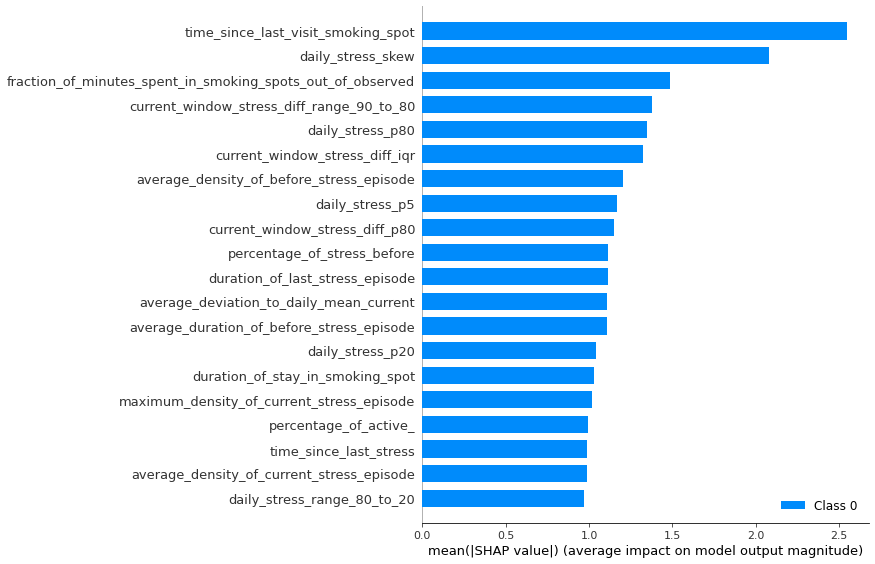

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.26930440331844285 AUC 0.5620044181556147 step 0 stagnant 0
Validation Result now 0.21164683782091423 AUC 0.5307344982771913 step 20 stagnant 0
Validation Result now 0.1835506519558676 AUC 0.5032032555611818 step 40 stagnant 20
Validation Result now 0.24146981627296588 AUC 0.5596001731979652 step 60 stagnant 40
Validation Result now 0.21841541755888652 AUC 0.5425664294777827 step 80 stagnant 60
Validation Result now 0.21557719054242 AUC 0.5318763394556465 step 100 stagnant 80
Validation Result now 0.2066420664206642 AUC 0.546186604938615 step 120 stagnant 100
Validation Result now 0.20058565153733526 AUC 0.5683053081961341 step 140 stagnant 120
Validation Result now 0.21709006928406463 AUC 0.5779204332174903 step 160 stagnant 140
Validation Result now 0.24251278305332358 AUC 0.5907963128865346 step 180 stagnant 160
Validation Result now 0.2145748987854251 AUC 0.5622966536562102 step 200 stagnant 180
Validation Result now 0.2253944402704733 AUC 0.571827281812091 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2347658755612572 AUC 0.6011097735875576 step 0 stagnant 0
Validation Result now 0.2596685082872928 AUC 0.5870729894228472 step 20 stagnant 0
Validation Result now 0.21955608878224353 AUC 0.5708726733221344 step 40 stagnant 0
Validation Result now 0.21645021645021642 AUC 0.5424411268089799 step 60 stagnant 20
Validation Result now 0.21330724070450097 AUC 0.5282486417128875 step 80 stagnant 40
Validation Result now 0.2085889570552147 AUC 0.552966447943439 step 100 stagnant 60
Validation Result now 0.20251396648044695 AUC 0.5711234847496554 step 120 stagnant 80
Validation Result now 0.21690862510674636 AUC 0.5363847624535498 step 140 stagnant 100
Validation Result now 0.21494542401343408 AUC 0.535503418928658 step 160 stagnant 120
Validation Result now 0.21919879062736206 AUC 0.5318369762817299 step 180 stagnant 140
Validation Result now 0.23105776444111029 AUC 0.5316182118361148 step 200 stagnant 160
Validation Result now 0.19748305905130686 AUC 0.5617653538532941

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22372881355932206 AUC 0.5477159982037203 step 0 stagnant 0
Validation Result now 0.2405255179383527 AUC 0.5747829203394466 step 20 stagnant 0
Validation Result now 0.26964769647696474 AUC 0.5558357347960772 step 40 stagnant 0
Validation Result now 0.23837902264600716 AUC 0.527540825897094 step 60 stagnant 0
Validation Result now 0.20867009551800147 AUC 0.5514325207001864 step 80 stagnant 20
Validation Result now 0.25194621372965326 AUC 0.5742736721575203 step 100 stagnant 40
Validation Result now 0.2579867389993972 AUC 0.5805308711358914 step 120 stagnant 60
Validation Result now 0.2584269662921348 AUC 0.5869705627346977 step 140 stagnant 80
Validation Result now 0.2450928381962865 AUC 0.5929497464166631 step 160 stagnant 100
Validation Result now 0.26131386861313866 AUC 0.6121878278761754 step 180 stagnant 120
Validation Result now 0.2663438256658595 AUC 0.5854132442860025 step 200 stagnant 140
Validation Result now 0.2554179566563467 AUC 0.6042074080668951 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24625407166123778 AUC 0.5508579420149535 step 0 stagnant 0
Validation Result now 0.23076923076923075 AUC 0.5355477282605536 step 20 stagnant 0
Validation Result now 0.24838292367399736 AUC 0.5470521825849487 step 40 stagnant 20
Validation Result now 0.23225806451612904 AUC 0.5594807440917627 step 60 stagnant 0
Validation Result now 0.24784313725490195 AUC 0.5505554020185683 step 80 stagnant 20
Validation Result now 0.24162836506894286 AUC 0.5657223832814914 step 100 stagnant 40
Validation Result now 0.24308588064046577 AUC 0.5701809325197728 step 120 stagnant 60
Validation Result now 0.24434389140271492 AUC 0.5732886654049841 step 140 stagnant 80
Validation Result now 0.23419827012641384 AUC 0.5733964504309443 step 160 stagnant 100
Validation Result now 0.2227027027027027 AUC 0.5443915617720518 step 180 stagnant 120
Validation Result now 0.24824952259707192 AUC 0.5561766075168 step 200 stagnant 140
Validation Result now 0.2579384465070836 AUC 0.59468729049672 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2778947368421053 AUC 0.6428018665975854 step 0 stagnant 0
Validation Result now 0.2357194504699928 AUC 0.5692277666592269 step 20 stagnant 0
Validation Result now 0.2546705998033432 AUC 0.597313803428553 step 40 stagnant 20
Validation Result now 0.25443330763299926 AUC 0.5778988968212896 step 60 stagnant 40
Validation Result now 0.25147347740667975 AUC 0.5667597368726391 step 80 stagnant 60
Validation Result now 0.24402515723270438 AUC 0.5697629821705431 step 100 stagnant 80
Validation Result now 0.30357142857142855 AUC 0.5839878233834153 step 120 stagnant 100
Validation Result now 0.25170068027210885 AUC 0.5872185919483554 step 140 stagnant 0
Validation Result now 0.2459546925566343 AUC 0.567723104184017 step 160 stagnant 20
Validation Result now 0.2627565982404692 AUC 0.5795595693627555 step 180 stagnant 40
Validation Result now 0.22614840989399296 AUC 0.5686804948878366 step 200 stagnant 60
Validation Result now 0.2147435897435897 AUC 0.5708941066733768 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.24600484261501213 AUC 0.5646369076950059 step 0 stagnant 0
Validation Result now 0.24727617243012787 AUC 0.6006472047715586 step 20 stagnant 0
Validation Result now 0.2488038277511962 AUC 0.5855638960144476 step 40 stagnant 0
Validation Result now 0.25174013921113686 AUC 0.5673391586708932 step 60 stagnant 0
Validation Result now 0.22827496757457846 AUC 0.5533672928296578 step 80 stagnant 0
Validation Result now 0.3011494252873563 AUC 0.6156463257980677 step 100 stagnant 20
Validation Result now 0.2844089091947459 AUC 0.6115476095527621 step 120 stagnant 0
Validation Result now 0.297896532120523 AUC 0.6133646012953575 step 140 stagnant 20
Validation Result now 0.23634204275534443 AUC 0.6003062290058779 step 160 stagnant 40
Validation Result now 0.25295508274231676 AUC 0.6148392776878195 step 180 stagnant 60
Validation Result now 0.2558303886925795 AUC 0.598096120748906 step 200 stagnant 80
Validation Result now 0.24311618535930152 AUC 0.5883562082835369 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3022471910112359 AUC 0.6049724138343214 step 0 stagnant 0
Validation Result now 0.24961160020714654 AUC 0.5349098799711721 step 20 stagnant 0
Validation Result now 0.27134986225895313 AUC 0.6255761501208408 step 40 stagnant 20
Validation Result now 0.2814698983580922 AUC 0.6102395568572194 step 60 stagnant 40
Validation Result now 0.24841571609632446 AUC 0.6057146466660526 step 80 stagnant 60
Validation Result now 0.26392067124332574 AUC 0.6120074991998559 step 100 stagnant 80
Validation Result now 0.2865627319970305 AUC 0.6243751611365529 step 120 stagnant 100
Validation Result now 0.28705882352941176 AUC 0.6260102785284603 step 140 stagnant 120
Validation Result now 0.2720970537261698 AUC 0.6288004268534336 step 160 stagnant 140
Validation Result now 0.3076923076923077 AUC 0.6186345265321188 step 180 stagnant 160
Validation Result now 0.28846153846153844 AUC 0.6013557419020574 step 200 stagnant 0
Validation Result now 0.3030769230769231 AUC 0.6047706518067594 

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


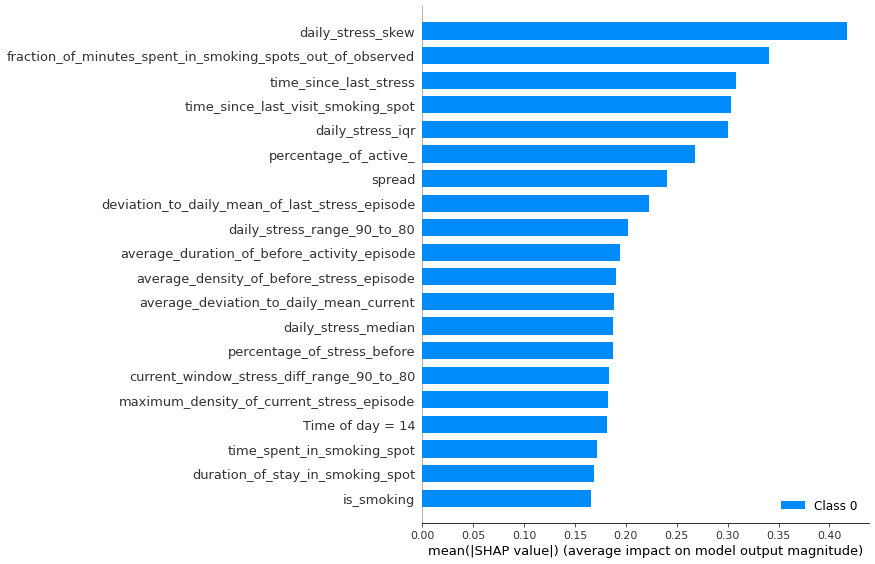

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.28924980665119876 AUC 0.6103525718434218 step 0 stagnant 0
Validation Result now 0.251595259799453 AUC 0.6212590031035911 step 20 stagnant 0
Validation Result now 0.24465355004277162 AUC 0.6230512303715103 step 40 stagnant 20
Validation Result now 0.2974358974358975 AUC 0.6656455537998502 step 60 stagnant 40
Validation Result now 0.26173826173826176 AUC 0.6494364475019467 step 80 stagnant 0
Validation Result now 0.2263374485596708 AUC 0.6163453148482482 step 100 stagnant 20
Validation Result now 0.2986175115207373 AUC 0.6458160726089407 step 120 stagnant 40
Validation Result now 0.2802768166089965 AUC 0.590761175833939 step 140 stagnant 0
Validation Result now 0.26328310864393334 AUC 0.5845231274753909 step 160 stagnant 20
Validation Result now 0.26064735945485523 AUC 0.5725565944180125 step 180 stagnant 40
Validation Result now 0.26666666666666666 AUC 0.5635436533421997 step 200 stagnant 60
Validation Result now 0.27021494370522003 AUC 0.568183155554641 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.27586206896551724 AUC 0.6440431593019105 step 0 stagnant 0
Validation Result now 0.23962516733601066 AUC 0.6131641069350838 step 20 stagnant 0
Validation Result now 0.2715008431703204 AUC 0.5906655085510305 step 40 stagnant 20
Validation Result now 0.2823779193205945 AUC 0.5843141034874515 step 60 stagnant 40
Validation Result now 0.28592927012791575 AUC 0.6016028060477607 step 80 stagnant 0
Validation Result now 0.2753403933434191 AUC 0.6120881207588258 step 100 stagnant 0
Validation Result now 0.27389014296463504 AUC 0.5959104222104052 step 120 stagnant 20
Validation Result now 0.2609340252038547 AUC 0.5721896291611207 step 140 stagnant 40
Validation Result now 0.25516224188790565 AUC 0.5754690314174967 step 160 stagnant 60
Validation Result now 0.27367055771725035 AUC 0.5986040879893517 step 180 stagnant 80
Validation Result now 0.27972972972972976 AUC 0.6125031001614791 step 200 stagnant 100
Validation Result now 0.25829216654904724 AUC 0.5982380252539967 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2232142857142857 AUC 0.5641088123285887 step 0 stagnant 0
Validation Result now 0.23168178646196788 AUC 0.6224234363904626 step 20 stagnant 0
Validation Result now 0.2438544739429695 AUC 0.6562988602597024 step 40 stagnant 0
Validation Result now 0.24324324324324326 AUC 0.6360749771571799 step 60 stagnant 0
Validation Result now 0.25468164794007486 AUC 0.6644782324440609 step 80 stagnant 20
Validation Result now 0.23508771929824562 AUC 0.6173648031762982 step 100 stagnant 0
Validation Result now 0.26807760141093473 AUC 0.675428526250922 step 120 stagnant 20
Validation Result now 0.23632038065027755 AUC 0.6299038958966678 step 140 stagnant 0
Validation Result now 0.25670945157526254 AUC 0.5722190513632227 step 160 stagnant 20
Validation Result now 0.23830734966592426 AUC 0.6092549251502788 step 180 stagnant 40
Validation Result now 0.242274412855377 AUC 0.6127924485662001 step 200 stagnant 60
Validation Result now 0.2327188940092166 AUC 0.6217346319535223 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2619047619047619 AUC 0.5935510504087159 step 0 stagnant 0
Validation Result now 0.26480836236933797 AUC 0.5727834883323821 step 20 stagnant 0
Validation Result now 0.29427792915531337 AUC 0.610886503584635 step 40 stagnant 0
Validation Result now 0.2472799208704253 AUC 0.5735659745048496 step 60 stagnant 0
Validation Result now 0.25355450236966826 AUC 0.5714232078720094 step 80 stagnant 20
Validation Result now 0.2509505703422053 AUC 0.5497697306550826 step 100 stagnant 40
Validation Result now 0.24822695035460993 AUC 0.562356476512599 step 120 stagnant 60
Validation Result now 0.2200247218788628 AUC 0.5445923256066659 step 140 stagnant 80
Validation Result now 0.22843822843822847 AUC 0.5700780897734563 step 160 stagnant 100
Validation Result now 0.2428722280887012 AUC 0.5771787682169459 step 180 stagnant 120
Validation Result now 0.23568281938325988 AUC 0.5745793256864489 step 200 stagnant 140
Validation Result now 0.23487544483985764 AUC 0.5812902953303174 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2803904170363798 AUC 0.5377425481504265 step 0 stagnant 0
Validation Result now 0.23223223223223222 AUC 0.5230240464228197 step 20 stagnant 0
Validation Result now 0.25536480686695284 AUC 0.5796977058263542 step 40 stagnant 20
Validation Result now 0.24541284403669725 AUC 0.46432747524654183 step 60 stagnant 40
Validation Result now 0.22561692126909516 AUC 0.4978512767250165 step 80 stagnant 60
Validation Result now 0.26693629929221435 AUC 0.5543413632479512 step 100 stagnant 80
Validation Result now 0.27319587628865977 AUC 0.5346963574591781 step 120 stagnant 100
Validation Result now 0.2920634920634921 AUC 0.5428315060882298 step 140 stagnant 120
Validation Result now 0.2817502668089648 AUC 0.5370598808599369 step 160 stagnant 0
Validation Result now 0.27504911591355596 AUC 0.5378557243511501 step 180 stagnant 20
Validation Result now 0.281661600810537 AUC 0.5178637892836037 step 200 stagnant 40
Validation Result now 0.29198682766191003 AUC 0.5050136876416282 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2305389221556886 AUC 0.5811987796464787 step 0 stagnant 0
Validation Result now 0.29066265060240964 AUC 0.5808437276738735 step 20 stagnant 0
Validation Result now 0.3009009009009009 AUC 0.5934640473325615 step 40 stagnant 0
Validation Result now 0.27565982404692085 AUC 0.5762035034442027 step 60 stagnant 0
Validation Result now 0.2888283378746594 AUC 0.6120807200822234 step 80 stagnant 20
Validation Result now 0.2618328298086606 AUC 0.550813045551706 step 100 stagnant 40
Validation Result now 0.2511144130757801 AUC 0.5724250067779367 step 120 stagnant 60
Validation Result now 0.28344895936570863 AUC 0.597855717130978 step 140 stagnant 80
Validation Result now 0.24678274034822104 AUC 0.5899380761923121 step 160 stagnant 100
Validation Result now 0.26955074875207985 AUC 0.5493280366149378 step 180 stagnant 120
Validation Result now 0.2690659811482433 AUC 0.5597476477581185 step 200 stagnant 140
Validation Result now 0.2915851272015656 AUC 0.5581648054867533 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.269589552238806 AUC 0.6191754418835698 step 0 stagnant 0
Validation Result now 0.2781065088757396 AUC 0.5924205519316308 step 20 stagnant 0
Validation Result now 0.29395348837209306 AUC 0.584132516154233 step 40 stagnant 0
Validation Result now 0.2904564315352697 AUC 0.6054509773766732 step 60 stagnant 0
Validation Result now 0.301255230125523 AUC 0.5964479640377659 step 80 stagnant 20
Validation Result now 0.3093220338983051 AUC 0.5939042973382475 step 100 stagnant 0
Validation Result now 0.3177366702937976 AUC 0.5856613876376933 step 120 stagnant 0
Validation Result now 0.30296827021494366 AUC 0.613409231784498 step 140 stagnant 0
Validation Result now 0.30359937402190923 AUC 0.602309480411131 step 160 stagnant 20
Validation Result now 0.31211498973305946 AUC 0.6117702526735396 step 180 stagnant 40
Validation Result now 0.32376395534290275 AUC 0.6421137487603866 step 200 stagnant 60
Validation Result now 0.3135391923990499 AUC 0.6302594893821951 step 220 stagn

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


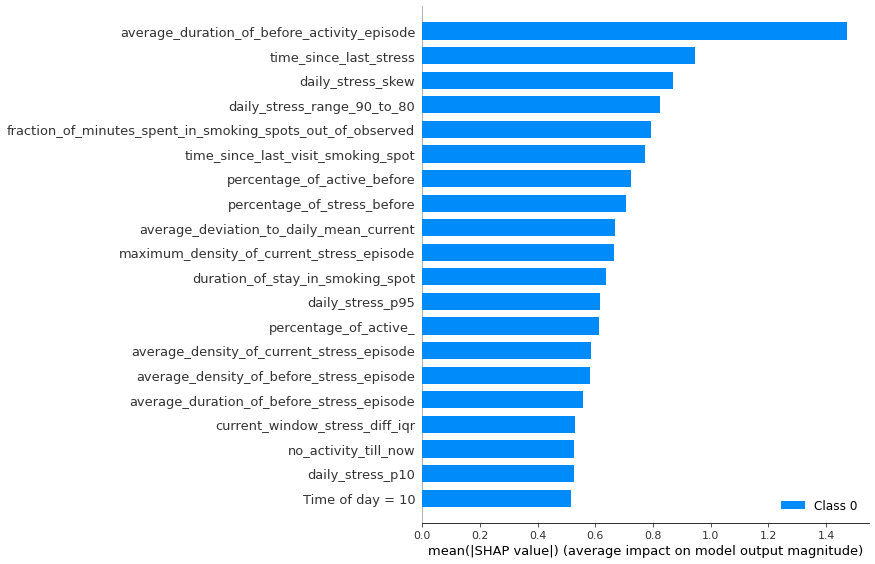

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.30696202531645567 AUC 0.6874816316034386 step 0 stagnant 0
Validation Result now 0.32432432432432434 AUC 0.6792127917513654 step 20 stagnant 0
Validation Result now 0.34240362811791386 AUC 0.7233972043300433 step 40 stagnant 0
Validation Result now 0.3115468409586057 AUC 0.6703089666348281 step 60 stagnant 0
Validation Result now 0.3411580594679186 AUC 0.7698827688112788 step 80 stagnant 20
Validation Result now 0.2762762762762763 AUC 0.6651765304956201 step 100 stagnant 40
Validation Result now 0.29000751314800904 AUC 0.7137617047504756 step 120 stagnant 60
Validation Result now 0.3179587831207066 AUC 0.7117674581404652 step 140 stagnant 80
Validation Result now 0.310828025477707 AUC 0.6618768521466533 step 160 stagnant 100
Validation Result now 0.2804347826086957 AUC 0.7110470088086664 step 180 stagnant 120
Validation Result now 0.2572509457755359 AUC 0.6675156947743952 step 200 stagnant 140
Validation Result now 0.1973171787105149 AUC 0.6108346497350868 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22895622895622894 AUC 0.5983921019976652 step 0 stagnant 0
Validation Result now 0.2873284907183212 AUC 0.6867193431461389 step 20 stagnant 0
Validation Result now 0.27811550151975684 AUC 0.6906075755349285 step 40 stagnant 0
Validation Result now 0.3094170403587444 AUC 0.6753663984880769 step 60 stagnant 20
Validation Result now 0.29068322981366457 AUC 0.6693137567044647 step 80 stagnant 0
Validation Result now 0.3330197554092192 AUC 0.6376997052892818 step 100 stagnant 20
Validation Result now 0.3392405063291139 AUC 0.7047966516454002 step 120 stagnant 0
Validation Result now 0.25750000000000006 AUC 0.6164015494762967 step 140 stagnant 0
Validation Result now 0.27743902439024387 AUC 0.7152301560089147 step 160 stagnant 20
Validation Result now 0.2995008319467554 AUC 0.7083971124880606 step 180 stagnant 40
Validation Result now 0.30088495575221236 AUC 0.6531926824389965 step 200 stagnant 60
Validation Result now 0.3585526315789474 AUC 0.7382345317691623 step 22

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.247000705716302 AUC 0.6518877609332777 step 0 stagnant 0
Validation Result now 0.3221601489757914 AUC 0.7169187729094723 step 20 stagnant 0
Validation Result now 0.3678696158323632 AUC 0.7164646653278146 step 40 stagnant 0
Validation Result now 0.34547908232118757 AUC 0.6982325010408759 step 60 stagnant 0
Validation Result now 0.3516260162601626 AUC 0.7439552668315741 step 80 stagnant 20
Validation Result now 0.3898305084745763 AUC 0.7250271444082519 step 100 stagnant 40
Validation Result now 0.4450474898236092 AUC 0.7458525691263992 step 120 stagnant 0
Validation Result now 0.36529680365296807 AUC 0.7035896949213424 step 140 stagnant 0
Validation Result now 0.37104072398190047 AUC 0.6928964818397785 step 160 stagnant 20
Validation Result now 0.3786816269284712 AUC 0.7005923297657826 step 180 stagnant 40
Validation Result now 0.33806451612903227 AUC 0.6801720302384627 step 200 stagnant 60
Validation Result now 0.4358974358974359 AUC 0.7640829475970055 step 220 s

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2336874051593323 AUC 0.6470660568359008 step 0 stagnant 0
Validation Result now 0.2896764252696456 AUC 0.6138036969459479 step 20 stagnant 0
Validation Result now 0.3727959697732997 AUC 0.6888875792902451 step 40 stagnant 0
Validation Result now 0.39951865222623345 AUC 0.6629713024417722 step 60 stagnant 0
Validation Result now 0.30808080808080807 AUC 0.611833431298115 step 80 stagnant 0
Validation Result now 0.29963459196102316 AUC 0.7188441380323773 step 100 stagnant 20
Validation Result now 0.32241379310344825 AUC 0.7162832774117704 step 120 stagnant 40
Validation Result now 0.35802469135802467 AUC 0.6866425530438474 step 140 stagnant 60
Validation Result now 0.30373230373230364 AUC 0.6764310001387834 step 160 stagnant 80
Validation Result now 0.39586410635155095 AUC 0.7244824704268815 step 180 stagnant 100
Validation Result now 0.37125748502994016 AUC 0.7062013237491122 step 200 stagnant 120
Validation Result now 0.3903903903903904 AUC 0.6905807882899431 ste

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2510748065348237 AUC 0.682465528642453 step 0 stagnant 0
Validation Result now 0.3378212974296206 AUC 0.6774394761333301 step 20 stagnant 0
Validation Result now 0.3931428571428571 AUC 0.6968362477855878 step 40 stagnant 0
Validation Result now 0.37670384138785623 AUC 0.695559644224568 step 60 stagnant 0
Validation Result now 0.38554216867469876 AUC 0.6888227796690423 step 80 stagnant 20
Validation Result now 0.3732162458836443 AUC 0.6908473851567029 step 100 stagnant 40
Validation Result now 0.43099273607748184 AUC 0.7242931738956512 step 120 stagnant 60
Validation Result now 0.4518430439952437 AUC 0.7396460920215849 step 140 stagnant 0
Validation Result now 0.42744656917885265 AUC 0.7112199778762869 step 160 stagnant 0
Validation Result now 0.4342857142857143 AUC 0.7173363988146261 step 180 stagnant 20
Validation Result now 0.4413472706155633 AUC 0.7140030450719633 step 200 stagnant 40
Validation Result now 0.4399038461538461 AUC 0.7315341488901406 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22817460317460314 AUC 0.6298173671148555 step 0 stagnant 0
Validation Result now 0.3103448275862069 AUC 0.6529214934730965 step 20 stagnant 0
Validation Result now 0.27777777777777773 AUC 0.646550466149086 step 40 stagnant 0
Validation Result now 0.33672316384180784 AUC 0.682728553876548 step 60 stagnant 20
Validation Result now 0.3232323232323232 AUC 0.6877551166189089 step 80 stagnant 0
Validation Result now 0.30373831775700927 AUC 0.6605711652910777 step 100 stagnant 20
Validation Result now 0.3421052631578947 AUC 0.6533110565501701 step 120 stagnant 40
Validation Result now 0.34564643799472294 AUC 0.6644190892540798 step 140 stagnant 0
Validation Result now 0.3463541666666667 AUC 0.6626595499334655 step 160 stagnant 0
Validation Result now 0.3472409152086138 AUC 0.6589792375890867 step 180 stagnant 0
Validation Result now 0.353099730458221 AUC 0.6392115263729355 step 200 stagnant 0
Validation Result now 0.337696335078534 AUC 0.6430242442425281 step 220 stagn

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3300970873786408 AUC 0.7160715306180763 step 0 stagnant 0
Validation Result now 0.40604751619870416 AUC 0.6850174601813981 step 20 stagnant 0
Validation Result now 0.3859649122807018 AUC 0.6697117386299625 step 40 stagnant 0
Validation Result now 0.35714285714285715 AUC 0.6652699031781408 step 60 stagnant 20
Validation Result now 0.4244105409153953 AUC 0.6568842199146073 step 80 stagnant 40
Validation Result now 0.4214876033057851 AUC 0.7150265729470255 step 100 stagnant 0
Validation Result now 0.3779677113010447 AUC 0.682666815654772 step 120 stagnant 20
Validation Result now 0.2830930537352555 AUC 0.6641956070959157 step 140 stagnant 40
Validation Result now 0.32305795314426633 AUC 0.6951501820512193 step 160 stagnant 60
Validation Result now 0.312 AUC 0.7202110528764909 step 180 stagnant 80
Validation Result now 0.32883435582822085 AUC 0.6439635836333504 step 200 stagnant 100
Validation Result now 0.35836627140974964 AUC 0.6571605112128857 step 220 stagnant 1

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


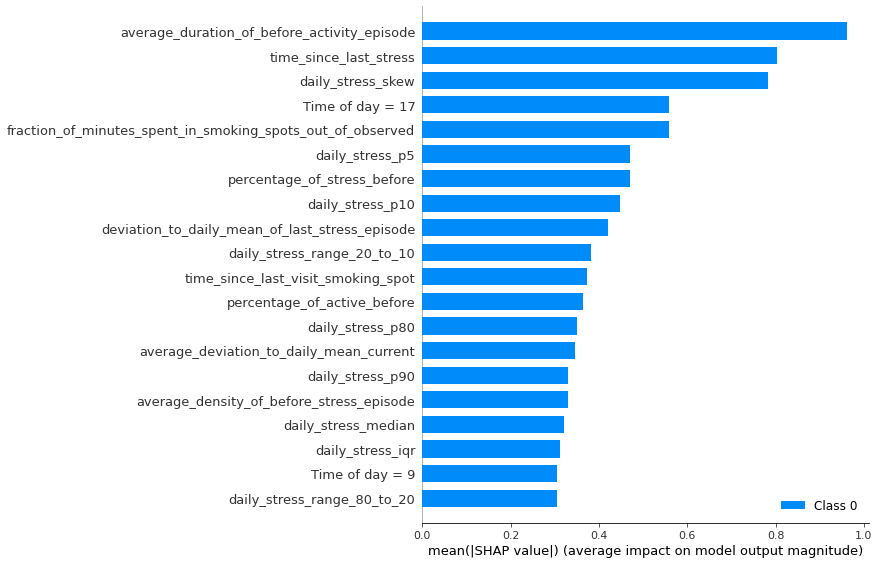

15 95


`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.22836752899197146 AUC 0.638132130480933 step 0 stagnant 0
Validation Result now 0.32894736842105265 AUC 0.6719565176263738 step 20 stagnant 0
Validation Result now 0.30623818525519847 AUC 0.6638567058873728 step 40 stagnant 0
Validation Result now 0.3154034229828851 AUC 0.6670386669656087 step 60 stagnant 20
Validation Result now 0.2903981264637002 AUC 0.6615464129577667 step 80 stagnant 40
Validation Result now 0.30028328611898014 AUC 0.6520510466256924 step 100 stagnant 60
Validation Result now 0.32592592592592595 AUC 0.6987803891371351 step 120 stagnant 80
Validation Result now 0.34782608695652173 AUC 0.6982220867948816 step 140 stagnant 100
Validation Result now 0.3591731266149871 AUC 0.6938935329106551 step 160 stagnant 0
Validation Result now 0.3352735739231665 AUC 0.7102895886475036 step 180 stagnant 0
Validation Result now 0.3225806451612903 AUC 0.7130772763701251 step 200 stagnant 20
Validation Result now 0.29555555555555557 AUC 0.6613636665530205 step 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3349397590361446 AUC 0.6711253032523627 step 0 stagnant 0
Validation Result now 0.36033857315598544 AUC 0.6986876070968399 step 20 stagnant 0
Validation Result now 0.34966887417218545 AUC 0.7254042056629648 step 40 stagnant 0
Validation Result now 0.3643979057591623 AUC 0.7573979085599785 step 60 stagnant 20
Validation Result now 0.3395291201982652 AUC 0.6481211938734066 step 80 stagnant 0
Validation Result now 0.3535108958837772 AUC 0.6638196735762787 step 100 stagnant 20
Validation Result now 0.3693803159173754 AUC 0.7008829791045185 step 120 stagnant 40
Validation Result now 0.374054054054054 AUC 0.7030489667783941 step 140 stagnant 0
Validation Result now 0.3733031674208145 AUC 0.6574732612625522 step 160 stagnant 0
Validation Result now 0.38031319910514544 AUC 0.6183810278639964 step 180 stagnant 20
Validation Result now 0.38639125151883347 AUC 0.7131732786113849 step 200 stagnant 0
Validation Result now 0.3837209302325582 AUC 0.7275542935945776 step 220 st

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.2528548123980424 AUC 0.611497848301968 step 0 stagnant 0
Validation Result now 0.27936507936507937 AUC 0.5661014677273473 step 20 stagnant 0
Validation Result now 0.2772680937818552 AUC 0.6119430410853366 step 40 stagnant 0
Validation Result now 0.3068493150684931 AUC 0.5980631698772741 step 60 stagnant 20
Validation Result now 0.27440633245382584 AUC 0.5663739772339844 step 80 stagnant 0
Validation Result now 0.26888604353393086 AUC 0.5766423930601449 step 100 stagnant 20
Validation Result now 0.2983870967741935 AUC 0.5771334737072604 step 120 stagnant 40
Validation Result now 0.3270440251572327 AUC 0.5474834733248617 step 140 stagnant 60
Validation Result now 0.31547619047619047 AUC 0.5708973532765745 step 160 stagnant 0
Validation Result now 0.3085714285714286 AUC 0.5728711352053704 step 180 stagnant 20
Validation Result now 0.3150492264416315 AUC 0.6129026609728148 step 200 stagnant 40
Validation Result now 0.3194444444444445 AUC 0.5718483188739599 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.18658088235294115 AUC 0.5712081026696673 step 0 stagnant 0
Validation Result now 0.3136308805790109 AUC 0.6737876043999216 step 20 stagnant 0
Validation Result now 0.32957110609480805 AUC 0.7025679492592933 step 40 stagnant 0
Validation Result now 0.3312217194570136 AUC 0.6966117850499755 step 60 stagnant 0
Validation Result now 0.37551867219917007 AUC 0.6556423757515648 step 80 stagnant 0
Validation Result now 0.39485981308411217 AUC 0.6318392540082445 step 100 stagnant 0
Validation Result now 0.3584699453551913 AUC 0.6816587818704296 step 120 stagnant 0
Validation Result now 0.32723577235772355 AUC 0.6392553768299295 step 140 stagnant 20
Validation Result now 0.29259589652096346 AUC 0.6834955039956656 step 160 stagnant 40
Validation Result now 0.2539325842696629 AUC 0.646581937812284 step 180 stagnant 60
Validation Result now 0.27007299270072993 AUC 0.6729819503710677 step 200 stagnant 80
Validation Result now 0.3076923076923077 AUC 0.7167992248976278 step 220

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3084702907711757 AUC 0.67957249417043 step 0 stagnant 0
Validation Result now 0.31570639305445936 AUC 0.7019227014909933 step 20 stagnant 0
Validation Result now 0.301498127340824 AUC 0.6944957104910524 step 40 stagnant 0
Validation Result now 0.39862542955326463 AUC 0.7173035888737226 step 60 stagnant 20
Validation Result now 0.32495511669658883 AUC 0.6797326991684234 step 80 stagnant 0
Validation Result now 0.35926993275696445 AUC 0.6752109332263153 step 100 stagnant 20
Validation Result now 0.3631647211413749 AUC 0.683888368513358 step 120 stagnant 40
Validation Result now 0.3023758099352052 AUC 0.6657314666365042 step 140 stagnant 60
Validation Result now 0.325635103926097 AUC 0.6896211312807504 step 160 stagnant 80
Validation Result now 0.3771428571428571 AUC 0.7335573519804437 step 180 stagnant 100
Validation Result now 0.3676814988290398 AUC 0.7330451387644974 step 200 stagnant 120
Validation Result now 0.37075718015665793 AUC 0.7342621734665906 step 220 

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.261744966442953 AUC 0.6500494904635762 step 0 stagnant 0
Validation Result now 0.26960784313725494 AUC 0.6356855827980085 step 20 stagnant 0
Validation Result now 0.16495575221238937 AUC 0.5448092976862454 step 40 stagnant 0
Validation Result now 0.19672131147540983 AUC 0.6069493144393409 step 60 stagnant 20
Validation Result now 0.1939729823346034 AUC 0.6103375696418775 step 80 stagnant 40
Validation Result now 0.15003261578604044 AUC 0.5507095109038017 step 100 stagnant 60
Validation Result now 0.17922077922077922 AUC 0.6079679042569849 step 120 stagnant 80
Validation Result now 0.190831159150205 AUC 0.6059542723412512 step 140 stagnant 100
Validation Result now 0.18509182571119911 AUC 0.6076006000844498 step 160 stagnant 120
Validation Result now 0.18963337547408346 AUC 0.5925678969310277 step 180 stagnant 140
Validation Result now 0.19776837245094264 AUC 0.6521542943191226 step 200 stagnant 160
Validation Result now 0.19816951850378034 AUC 0.6535236847793578

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Validation Result now 0.3414634146341463 AUC 0.6498017362518551 step 0 stagnant 0
Validation Result now 0.2920353982300885 AUC 0.6978664558508435 step 20 stagnant 0
Validation Result now 0.32214765100671144 AUC 0.685592659873921 step 40 stagnant 20
Validation Result now 0.33236994219653176 AUC 0.6506500579434912 step 60 stagnant 40
Validation Result now 0.31848852901484476 AUC 0.6394713315571241 step 80 stagnant 60
Validation Result now 0.30095759233926134 AUC 0.6582124986465092 step 100 stagnant 80
Validation Result now 0.30727023319615915 AUC 0.6581370251863994 step 120 stagnant 100
Validation Result now 0.29612220916568743 AUC 0.666477546947511 step 140 stagnant 120
Validation Result now 0.3070175438596492 AUC 0.6696275072786605 step 160 stagnant 140
Validation Result now 0.29333333333333333 AUC 0.6431775816049241 step 180 stagnant 160
Validation Result now 0.2908093278463649 AUC 0.576558064047382 step 200 stagnant 180
Validation Result now 0.32248520710059175 AUC 0.6521712003741874

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode. See PR #1483 for discussion.
You have provided over 5k background samples! For better performance consider using smaller random sample.


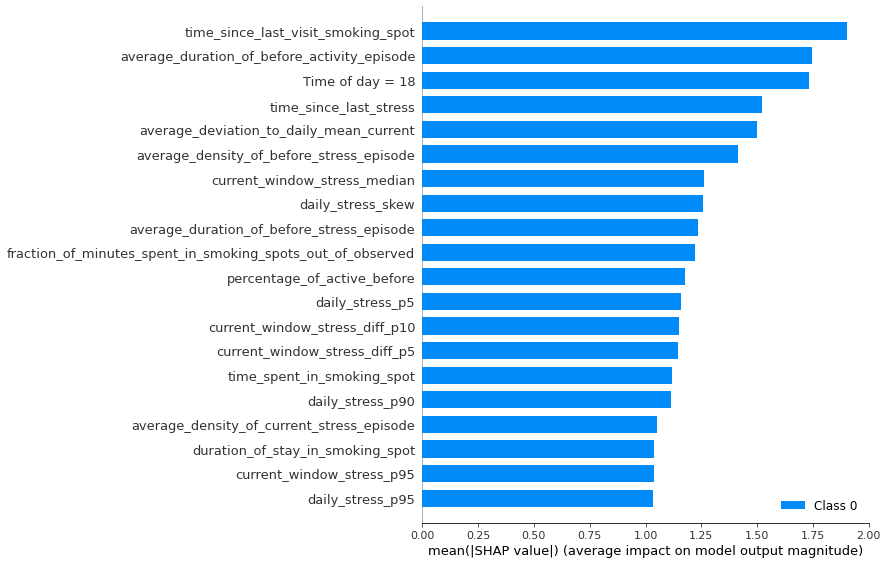

In [3]:
n_lag = 15
obs = 30
n_cluster = 4
n_iters = 7
softmax_weight = 10
revised_loss_weight = 50
batch_size = 200
n_epochs = 1000
n_step = 20
ratio_of_pos_to_neg = .35
gpu_id = 2
set_gpu()
tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()
filepath_file = './data/episode_encoded_lagged_data_without_episode/episode_encoded_'+'lagged_'+str(n_lag)+'_obs_{}'.format(obs)+'_windows_with_episode_cluster_check_{}'.format(n_cluster)
X_feature,X_static,X_stress_episode,X_quit_episode,X_activity_episode,X_smoking_episode,y_time,y,groups = get_X_y_groups(n_lag)
X_feature = np.nan_to_num(X_feature)
indexes = get_train_test_indexes(groups,n_groups_split = 20,n_val_groups=10)
explannation_data = []
for kk,yyyy in enumerate(indexes):
    train_index,test_index,val_index = yyyy
    X_feature_train,X_feature_test = X_feature[train_index],X_feature[test_index]
    X_static_train,X_static_test = X_static[train_index],X_static[test_index]
    X_stress_episode_train,X_stress_episode_test = X_stress_episode[train_index], X_stress_episode[test_index]
    X_quit_episode_train,X_quit_episode_test = X_quit_episode[train_index], X_quit_episode[test_index]
    X_activity_episode_train,X_activity_episode_test = X_activity_episode[train_index], X_activity_episode[test_index]
    X_smoking_episode_train,X_smoking_episode_test = X_smoking_episode[train_index], X_smoking_episode[test_index]
    y_train,y_test,groups_train,groups_test,time_train,time_test = y[train_index],y[test_index],groups[train_index],groups[test_index],y_time[train_index],y_time[test_index]
    
    X_feature_val,X_static_val,X_stress_episode_val,X_quit_episode_val,\
    X_activity_episode_val,X_smoking_episode_val,y_val,groups_val,time_val = X_feature[val_index],X_static[val_index],X_stress_episode[val_index],X_quit_episode[val_index],\
                                                                            X_activity_episode[val_index],X_smoking_episode[val_index],y[val_index],groups[val_index],y_time[val_index]
    
    X_feature_train,val_feature,\
    X_static_train,val_static,\
    X_stress_episode_train,val_stress,\
    X_smoking_episode_train,val_smoking,\
    X_quit_episode_train,val_quit,\
    X_activity_episode_train,val_activity, \
    y_train,val_y = train_test_split(
                                    X_feature_train,
                                    X_static_train,
                                    X_stress_episode_train,
                                    X_smoking_episode_train,
                                    X_quit_episode_train,
                                    X_activity_episode_train,
                                    y_train,
                                    test_size=.05,
                                    stratify=y_train
                                    )
    val_feature = np.concatenate([val_feature,X_feature_val])
    val_static = np.concatenate([val_static,X_static_val])
    val_stress = np.concatenate([val_stress,X_stress_episode_val])
    val_activity = np.concatenate([val_activity,X_activity_episode_val])
    val_smoking = np.concatenate([val_smoking,X_smoking_episode_val])
    val_quit = np.concatenate([val_quit,X_quit_episode_val])
    val_y = np.array(list(val_y)+list(y_val))
    
    positive_train_index = np.where(y_train==1)[0]
    negative_train_index = np.where(y_train==0)[0]
    len_positive = len(positive_train_index)
    all_models = []
    for iter in range(n_iters):
        indexes_sampled = np.array(list(positive_train_index)+list(np.random.choice(negative_train_index,len_positive,replace=False)))
        train_feature = np.float64(X_feature_train[indexes_sampled])
        train_static = X_static_train[indexes_sampled]
        train_stress = X_stress_episode_train[indexes_sampled]
        train_quit = X_quit_episode_train[indexes_sampled]
        train_activity = X_activity_episode_train[indexes_sampled]
        train_smoking = X_smoking_episode_train[indexes_sampled]
        train_y = np.float64(y_train[indexes_sampled])
        model = get_model()
        # model.summary()
        validation_results = [0]
        counter_ = 0
        best_filepath = None
        for iiii in np.arange(0,n_epochs,n_step):
            filepath = './models/lag_'+str(n_lag)+'_iter_'+str(n_iters)+'_temp_with_episode_revised_loss_2_80_.2{}{}{}{}.hdf5'.format(softmax_weight,revised_loss_weight,ratio_of_pos_to_neg,iiii)
            checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
            es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience=60)
            callbacks_list = [es,checkpoint]
            model.fit(train_feature,[train_y,train_y],
                      epochs=n_step, batch_size=batch_size,
                      verbose=0,callbacks=callbacks_list,shuffle=True)
            if os.path.isfile(filepath):
                model.load_weights(filepath)
            val_y_pred = model.predict(val_feature)[0]
            val_f1_now = f1Bias_scorer_CV(val_y_pred,val_y)[0]
            # print('<->'*20)
            from sklearn.metrics import roc_auc_score
            print('Validation Result now',val_f1_now,'AUC',roc_auc_score(val_y,val_y_pred),'step',iiii,'stagnant',counter_)
            # print('<->'*20)
            if val_f1_now>=max(validation_results):
                best_filepath = filepath
                counter_ = 0
            else:
                counter_ += n_step
                if counter_>200:
                    break
            validation_results.append(val_f1_now)
        if os.path.isfile(best_filepath):
            print()
            print(best_filepath[-15:])
            model.load_weights(best_filepath)
        model_this_iter = tf.keras.models.Model(model.input,model.get_layer('softmax').output)
        all_models.append(model_this_iter)
        print(len(all_models))
    model_input = all_models[0].input
    model_outputs = [model(model_input) for model in all_models]
    ensemble_output = tf.keras.layers.Average()(model_outputs)
    ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
    train_data = get_random_samples(X_feature_train,y_train)
    test_data = get_random_samples(X_feature_test,y_test)
    explainer = shap.DeepExplainer(ensemble_model,train_data)
    shap_values = explainer.shap_values(test_data,check_additivity=False)
    plt.figure()
    shap.summary_plot([shap_values[0].mean(axis=1)], test_data.mean(axis=1),feature_names=feature_names)
    plt.show()
    explannation_data.append([shap_values,test_data])
    pickle.dump(explannation_data,open('./data/explannation_data_v1.p','wb'))

In [ ]:
model_input = all_models[0].input
model_outputs = [model(model_input) for model in all_models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.predict(X_feature_test).shape,X_feature_test.shape,y_test.shape,X_feature_train.shape,y_train.shape

In [ ]:
ensemble_model.summary()

In [ ]:
import shap

# we use the first 100 training examples as our background dataset to integrate over
def get_random_samples(X_feature_train,y_train):
    train_positive = X_feature_train[y_train==1]
    train_negative = X_feature_train[y_train==0]
    train_negative = train_negative[np.random.choice(np.arange(train_negative.shape[0]),train_positive.shape[0])]
    X_feature_train = np.concatenate([train_positive,train_negative])
    return X_feature_train
train_data = get_random_samples(X_feature_train,y_train)
test_data = get_random_samples(X_feature_test,y_test)


In [ ]:
explainer = shap.DeepExplainer(ensemble_model,X_feature_train)
shap_values = explainer.shap_values(test_data,check_additivity=False)

In [ ]:
# shap_values[0].sum(axis=1).
# 



In [ ]:
?shap.summary_plot

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0].sum(axis=1)[0], val_feature.mean(axis=1)[0],feature_names=feature_names)

In [ ]:
?shap.summary_plot

In [ ]:
X_feature_test[:10].mean(axis=1).shape